# Data Scientist Professional Case Study

### Company Background

Nearly New Nautical is a website that allows users to advertise their used boats for sale. When users list their boat, they have to provide a range of information about their boat. Boats that get lots of views bring more traffic to the website, and more potential customers. 

To boost traffic to the website, the product manager wants to prevent listing boats that do not receive many views.




### Customer Question

The product manager wants to know the following:
- Can you predict the number of views a listing will receive based on the boat's features?



### Success Criteria

The product manager would consider using your model if, on average, the predictions were only 50% off of the true number of views a listing would receive.


### Dataset

The data you will use for this analysis can be accessed here: `"data/boat_data.csv"`

### Data Dictionary

The data set has the following columns:
* **Price**: Character, boat price listed in different currencies (e.g. EUR, Â£, CHF etc.) on the website
* **Boat Type**: Character, type of the boat
* **Manufacturer**: Character, manufacturer of the boat
* **Type**: Character, condition of the boat and engine type (e.g. Diesel, Unleaded, etc.)
* **Year Built**: Numeric, year of the boat built
* **Length**: Numeric, length in meter of the boat
* **Width**: Numeric, width in meter of the boat
* **Material**: Character, material of the boat (e.g. GRP, PVC, etc.)
* **Location**: Character, location of the boat is listed
* **Number of views last 7 days**: Numeric, number of the views of the list last 7 days 

# <span style="color:#0066CC">Imports and Preliminary Data View</span>
The analysis will commence with importing all the necessary data packages to conduct this assessment. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import missingno as msno
import geopandas
import numpy as np

Customizing the global behavior related to DataFrame display.

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

sns.set(rc={'figure.figsize':(10, 7)}, style='darkgrid')

Since we are going to be updating our table, it would be wise to create a copy of the original dataset.

In [3]:
data = pd.read_csv('data/boat_data.csv')
data_copy = data.copy()

Let's take a quick view on what our data looks like.

In [4]:
display(data.head())
print(f'The dataset has {data.shape[0]} rows and {data.shape[1]} columns')

,Price,Boat Type,Manufacturer,Type,Year Built,Length,Width,Material,Location,Number of views last 7 days
0,CHF 3337,Motor Yacht,Rigiflex power boats,new boat from stock,2017,4.00,1.90,NaN,Switzerland Â» Lake Geneva Â» VÃ©senaz,226
1,EUR 3490,Center console boat,Terhi power boats,new boat from stock,2020,4.00,1.50,Thermoplastic,Germany Â» BÃ¶nningstedt,75
2,CHF 3770,Sport Boat,Marine power boats,new boat from stock,0,3.69,1.42,Aluminium,Switzerland Â» Lake of Zurich Â» StÃ¤fa ZH,124
3,DKK 25900,Sport Boat,Pioner power boats,new boat from stock,2020,3.00,1.00,NaN,Denmark Â» Svendborg,64
4,EUR 3399,Fishing Boat,Linder power boats,new boat from stock,2019,3.55,1.46,Aluminium,Germany Â» Bayern Â» MÃ¼nchen,58


The dataset has 9888 rows and 10 columns


A quick glimpse of the data shows us that there are some missing values in the materials column and a zero value in the year-built column. Also there seems to be an encoding issue with the location column.

Let's print the information about the DataFrame to see the index dtype, non-null values and memory usage.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9888 entries, 0 to 9887
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Price                        9888 non-null   object 
 1   Boat Type                    9888 non-null   object 
 2   Manufacturer                 8550 non-null   object 
 3   Type                         9882 non-null   object 
 4   Year Built                   9888 non-null   int64  
 5   Length                       9879 non-null   float64
 6   Width                        9832 non-null   float64
 7   Material                     8139 non-null   object 
 8   Location                     9852 non-null   object 
 9   Number of views last 7 days  9888 non-null   int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 772.6+ KB


# <span style="color:#0066CC">Data Cleaning</span>
This is a fundamental step before any analysis can be performed. It will overall improve our data quality and remove any sort of errors in it, leading to better decision makings and conclusions.

We’ll analyze each column separately.

### Price Column

In [6]:
data['Price'].head()

0     CHF 3337
1     EUR 3490
2     CHF 3770
3    DKK 25900
4     EUR 3399
Name: Price, dtype: object

We can see that the currency and amounts are together. We will need to split them up.

In [7]:
# Split Price coulum and create a new column named Currency and overwrite the Price column
data[['Currency', 'Price']] = data_copy['Price'].str.split(' ', expand=True)

# Convert Currency dtype to category and Price dytpe to int
data['Currency'] = data['Currency'].astype('category')
data['Price'] = data['Price'].astype('int')

There is some encoding issues with one value. Â£ is mojibake for a pound sign. Let's rename it to GBP

In [8]:
data['Currency'] = data['Currency'].replace({'Â£': 'GBP'})

Text(0.5, 0, 'Count')

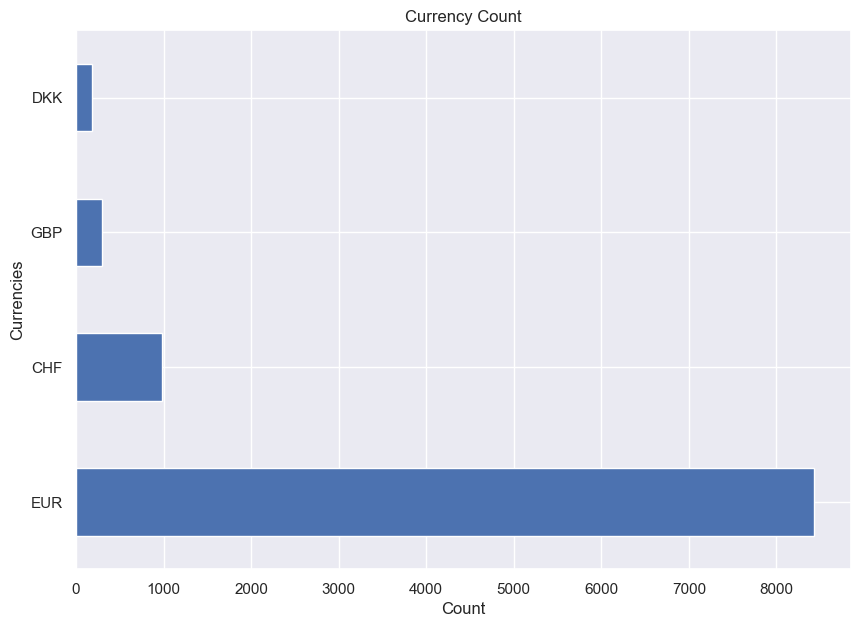

In [9]:
# Let's inspect the Currency column
ax = data['Currency'].value_counts().plot.barh(title='Currency Count')
ax.set_ylabel("Currencies")
ax.set_xlabel("Count")

We can see how boats listed in Euros are the most common.

Let’s display the distribution of the Currency column against the Number of views last 7 days. Well do this using a boxplot which enables us to identify the mean values, the dispersion of the data as well as any sign of skewness.

[None]

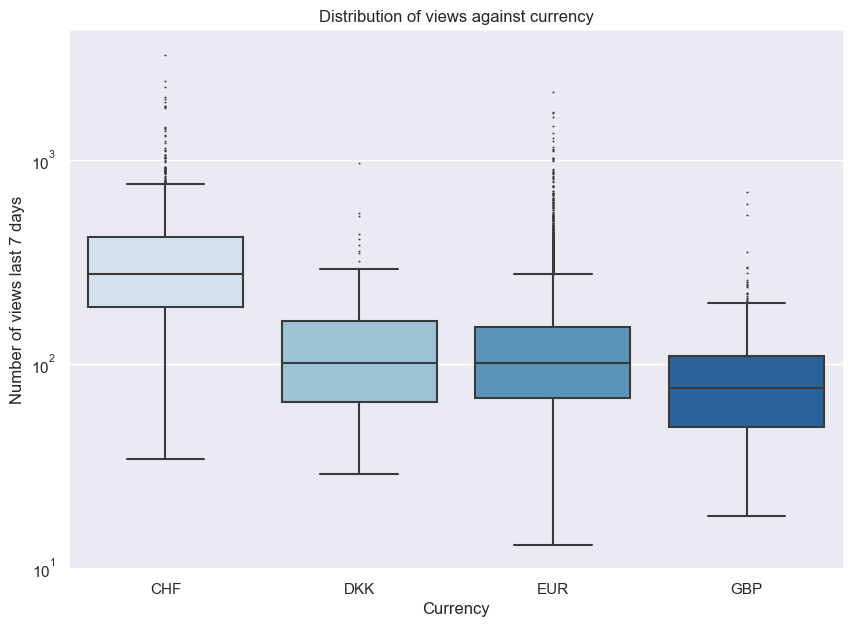

In [10]:
ax = sns.boxplot(data=data, x='Currency', y='Number of views last 7 days', palette="Blues", fliersize=0.5)
ax.set(title='Distribution of views against currency')
ax.set(yscale="log")

Boats listed in Swiss Franc (CHF) are much more popular than those in other currencies. However, we can’t deny that boats listed in Euro (EUR) have many outliers.

We should also check if there is any relationship with Price and the Number of views last 7 days. Since we are working with different currencies and thus different exchange rates, it would be wise to separate them.

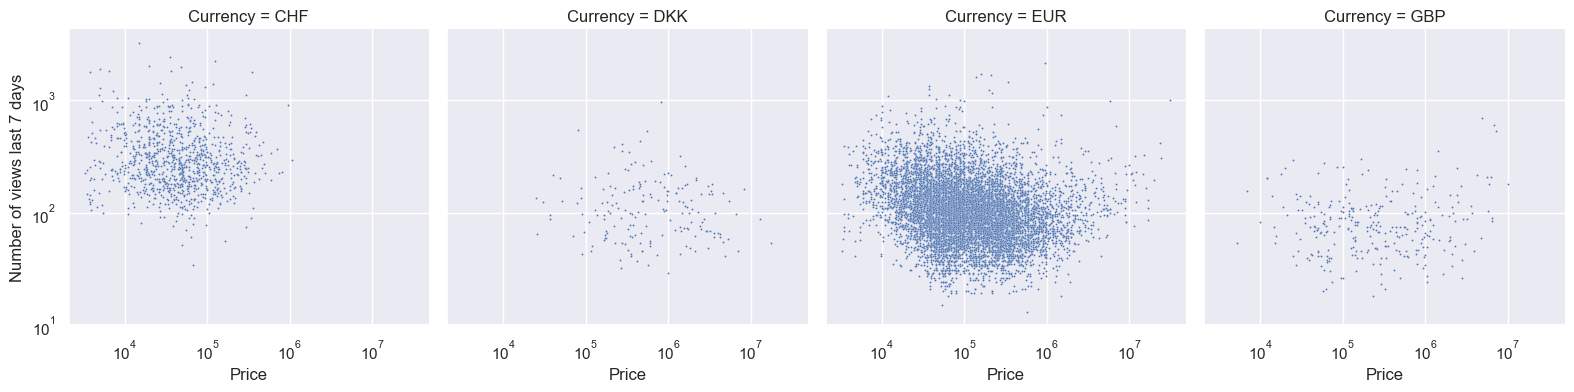

In [11]:
ax = sns.FacetGrid(data, col='Currency', height=4, aspect=1)
ax.map(sns.scatterplot, 'Price', 'Number of views last 7 days', palette='Blues', s=2)
ax.set(xscale='log')
ax.set(yscale='log')

It seems that the four currencies behave in the same way, visually there isn’t much correlation between Price and Number of views last 7 days.

It would be easier if worked with a single currency, lets standardize the price. To do this, we will need to covert each currency using the exchange rate.

In [12]:
rates = {
    'CHF': 1.03,
    'EUR': 1,
    'GBP': 0.88,
    'DKK': 7.44
}

data['Price'] = data['Price'] / data['Currency'].replace(rates).astype('float')
data['Price'] = data['Price'].astype('int')

It could be useful to create different price groups. Let’s inspect the Price column by calculating the descriptive statistics.

In [13]:
display(data['Price'].describe())

count    9.888000e+03
mean     3.020206e+05
std      9.687450e+05
min      3.239000e+03
25%      4.296500e+04
50%      9.200000e+04
75%      2.480000e+05
max      3.100000e+07
Name: Price, dtype: float64

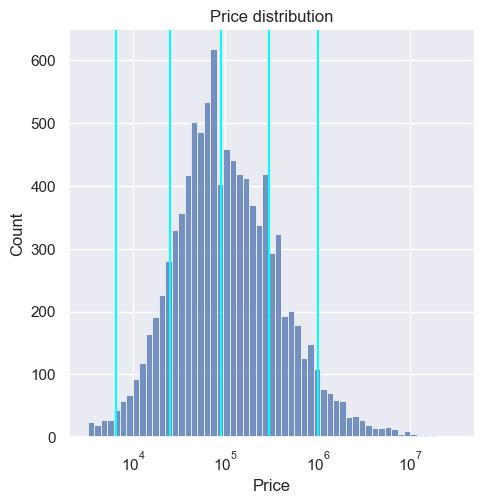

In [14]:
ax = sns.displot(data, x='Price', log_scale=True)
ax.set(title='Price distribution')

price_groups = [6500, 25000, 90000, 300000, 1000000]
for x in price_groups:
    plt.axvline(x=x, color='cyan')
    
price_groups.append(data['Price'].max()+1)
price_groups.insert(0, data['Price'].min()-1)

Let’s divide the prices into six groups. Very Cheap, Cheap, Affordable, Costly, Expensive, Luxury 

In [15]:
data['Price Category'] = pd.cut(data['Price'], 
                                bins=price_groups,
                                labels=['Very Cheap', 'Cheap', 'Modest', 'Costly', 'Expensive', 'Luxury'])

### Boat Type Column

In [16]:
display(data['Boat Type'].head())
display(pd.Series(data['Boat Type'].unique()).tail())

0            Motor Yacht
1    Center console boat
2             Sport Boat
3             Sport Boat
4           Fishing Boat
Name: Boat Type, dtype: object

121                   Deck Boat,Water ski
122                  Classic,Fishing Boat
123                    Hardtop,Sport Boat
124    Cabin Boat,Fishing Boat,Sport Boat
125              Classic,Runabout,Trawler
dtype: object

At first glance it seems that there are 126 unique types, however many boats share types separated by a comma. Let’s split them. 

In [17]:
# For each boat we are going to create a list of boat types.
data['Boat Type'] = data_copy['Boat Type'].str.split(',')
display(pd.Series(data['Boat Type'].explode().value_counts()))

Motor Yacht            2812
Sport Boat             1494
Flybridge              1218
Trawler                 702
Cabin Boat              655
Pilothouse              622
Hardtop                 521
Center console boat     378
Bowrider                310
Deck Boat               292
Classic                 221
Fishing Boat            187
House Boat              157
Runabout                142
Mega Yacht              110
Pontoon Boat             96
Wakeboard/Wakesurf       73
Launch                   60
Offshore Boat            58
Working Boat             50
Passenger boat           40
Water ski                30
Catamaran                26
Motorsailer               4
Ketch                     1
RIB                       1
Name: Boat Type, dtype: int64

There are 26 unique boat types. Let’s see how many boats have shared boat types.

In [18]:
data[data['Boat Type'].str.len() > 1].shape[0]

296

It’s much easier to work with categorial values than with lists. If a boat shares more than one type, let’s just assume it’s the first one from the list.

In [19]:
data['Boat Type'] = data['Boat Type'].str[0]

There are some boat types with very few entries, lest drop these.

In [20]:
drop_boats = ['RIB', 'Ketch', 'Motorsailer', 'Water ski']
data = data[~data['Boat Type'].isin(drop_boats)]

Text(0.5, 0, 'Count')

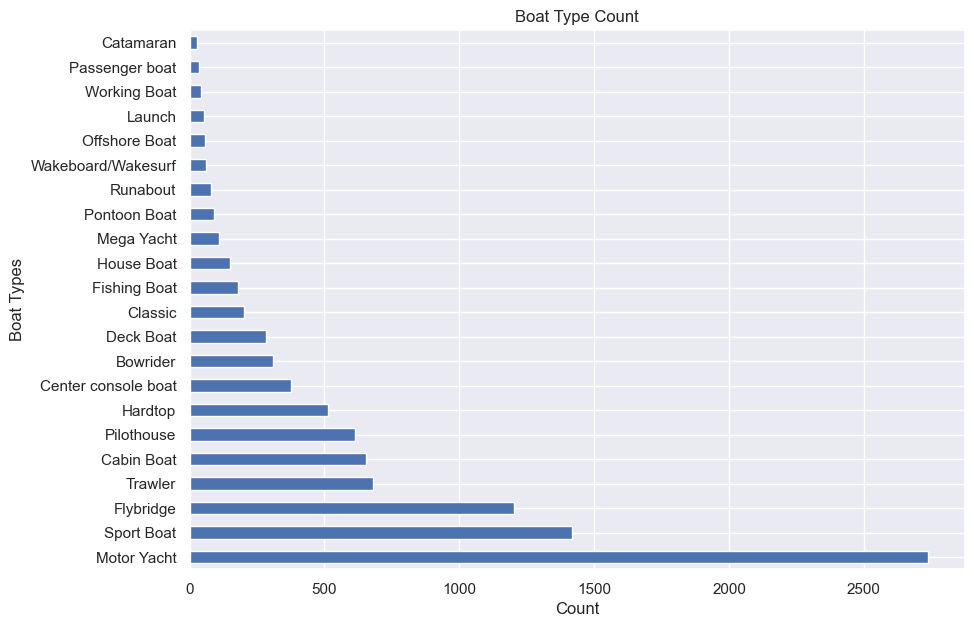

In [21]:
# Let's inspect the Boat Type column
ax = data['Boat Type'].value_counts().plot.barh(title='Boat Type Count')
ax.set_ylabel("Boat Types")
ax.set_xlabel("Count")

The data is quite imbalanced. Motor Yachts and Sport Boats are way more prevalent than the other types.

Let’s display the distribution of each Boat Type against the Number of views last 7 days.

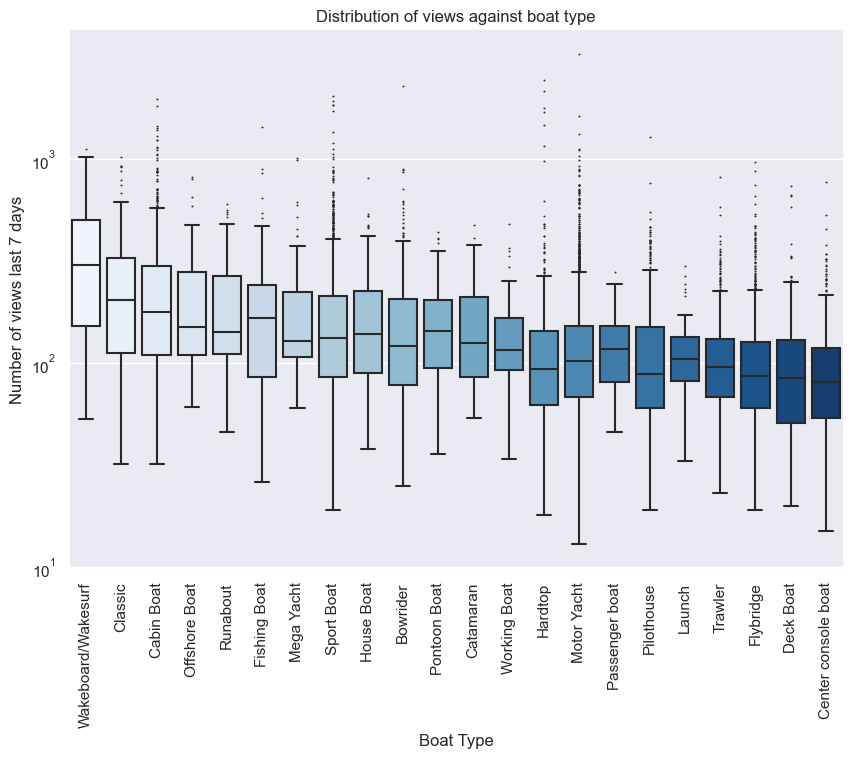

In [22]:
boat_type_mean = pd.DataFrame(data.groupby('Boat Type')['Number of views last 7 days'].mean().sort_values(ascending=False))
ax = sns.boxplot(data=data, x='Boat Type', y='Number of views last 7 days', palette="Blues", fliersize=0.5, order=boat_type_mean.index)
ax.set(title='Distribution of views against boat type')
ax.set(yscale="log")
ax.tick_params(axis='x', rotation=90)

Its seems that the smaller boats are the most popular. People seem more interested in recreational or fun boats.

### Manufacturer Column

In [23]:
data['Manufacturer'].value_counts().head()

BÃ©nÃ©teau power boats    631
Jeanneau power boats      537
Sunseeker power boats     383
Princess power boats      241
Sea Ray power boats       239
Name: Manufacturer, dtype: int64

There is an encoding issue we need to fix as well as a redundant power boats at the end of each manufacturer.

Let’s see how many different boat Manufacturers there are.

In [24]:
print(f'Number of unique boat manufacturers: {data["Manufacturer"].nunique()}')

Number of unique boat manufacturers: 909


Let’s create a function that re encodes the string into the correct format.

In [25]:
re_encode = lambda x: str(x).encode('latin-1').decode('utf-8')

In [26]:
# Removing the ‘power boat’ substring from the Manufacturer column
data['Manufacturer'] = data_copy['Manufacturer'].str.replace(' power boats', '')

# Encoding the data
data['Manufacturer'] = data['Manufacturer'].apply(re_encode)

# Parsing NaN strings into NaN objects
data['Manufacturer'] = data['Manufacturer'].replace({'nan': np.nan})

There are hundreds of boat manufacturers, lets visualize how the most frequent boat manufacturers compare.

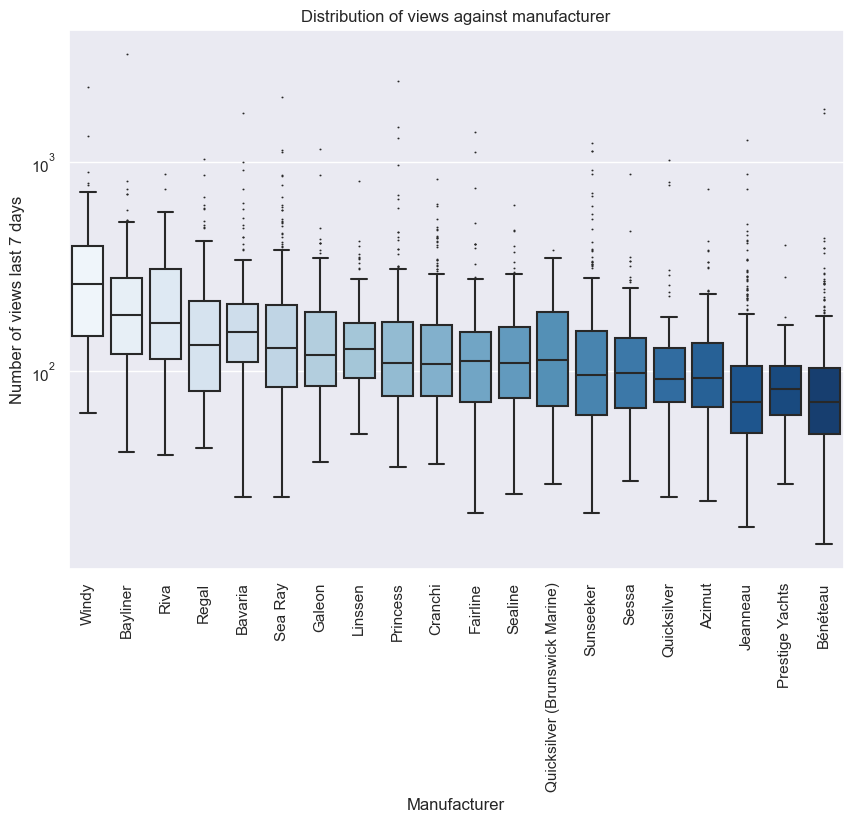

In [27]:
most_frequent_manufacturer = data['Manufacturer'].value_counts().head(20).index
manufacturer_mean = pd.DataFrame(data[data['Manufacturer'].isin(most_frequent_manufacturer)].groupby('Manufacturer')['Number of views last 7 days'].mean().sort_values(ascending=False))

ax = sns.boxplot(data=data[data['Manufacturer'].isin(most_frequent_manufacturer)], x='Manufacturer', y='Number of views last 7 days', palette="Blues", fliersize=0.5, order=manufacturer_mean.index)
ax.set(title='Distribution of views against manufacturer')
ax.set(yscale="log")
ax.tick_params(axis='x', rotation=90)

Windy is by far the most popular manufacturer of those in the topmost frequent list.

### Type Column

In [28]:
data['Type'].value_counts()

Used boat,Diesel                4137
Used boat,Unleaded              1680
Used boat                       1459
new boat from stock,Unleaded    1107
new boat from stock              665
new boat from stock,Diesel       291
new boat on order,Unleaded       148
Display Model,Unleaded            75
new boat on order                 61
new boat on order,Diesel          61
Diesel                            56
Used boat,Electric                27
Unleaded                          22
Display Model,Diesel              19
new boat from stock,Electric      18
Display Model                     18
Used boat,Gas                     10
Display Model,Electric             6
new boat from stock,Gas            2
new boat from stock,Hybrid         1
Used boat,Hybrid                   1
Display Model,Gas                  1
Electric                           1
Used boat,Propane                  1
Name: Type, dtype: int64

Upon inspecting this column, we can see that it is composed of both its condition and its fuel type. We will need to split them up.

In [29]:
data[['Condition', 'Fuel Type']] = data_copy['Type'].str.split(',', expand=True)

# Let's drop the Type column
data = data.drop('Type', axis=1)

Let’s inspect the Condition column, since the split was done assuming that all boats had both a condition and a fuel type. 

In [30]:
data['Condition'].value_counts()

Used boat              7315
new boat from stock    2084
new boat on order       270
Display Model           119
Diesel                   56
Unleaded                 22
Electric                  1
Name: Condition, dtype: int64

Some boats have only fuel type making them after the split go into the condition column. We need to fix this.

In [31]:
fuel_types = ['Gas', 'Propane', 'Electric', 'Hybrid', 'Diesel', 'Unleaded']

# Let’s move the fuel types from the Condition column to the Fuel Type column
contains_fuel = data['Condition'].isin(fuel_types)
data.loc[contains_fuel, ['Condition', 'Fuel Type']] = (data.loc[contains_fuel, ['Fuel Type', 'Condition']].values)

# Let’s check if the columns contain the correct values
display(data['Fuel Type'].value_counts())
display(data['Condition'].value_counts())

Diesel      4564
Unleaded    3032
Electric      52
Gas           13
Hybrid         2
Propane        1
Name: Fuel Type, dtype: int64

Used boat              7315
new boat from stock    2084
new boat on order       270
Display Model           119
Name: Condition, dtype: int64

The sample size for some fuel types is very low. Let’s drop these values.

In [32]:
drop_fuels = ['Propane', 'Hybrid', 'Gas']
data = data[~data['Fuel Type'].isin(drop_fuels)]

Text(0.5, 0, 'Count')

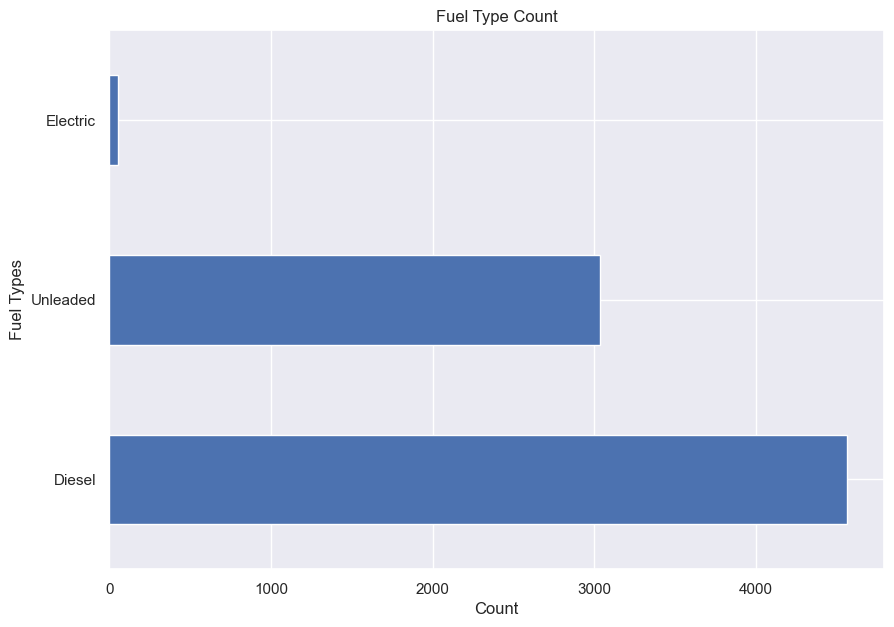

In [33]:
# Let's inspect the Fuel Type column
ax = data['Fuel Type'].value_counts().plot.barh(title='Fuel Type Count')
ax.set_ylabel("Fuel Types")
ax.set_xlabel("Count")

The amount of Electric and Gas powered boats are almost none compared to Diesel and Unleaded.

[None]

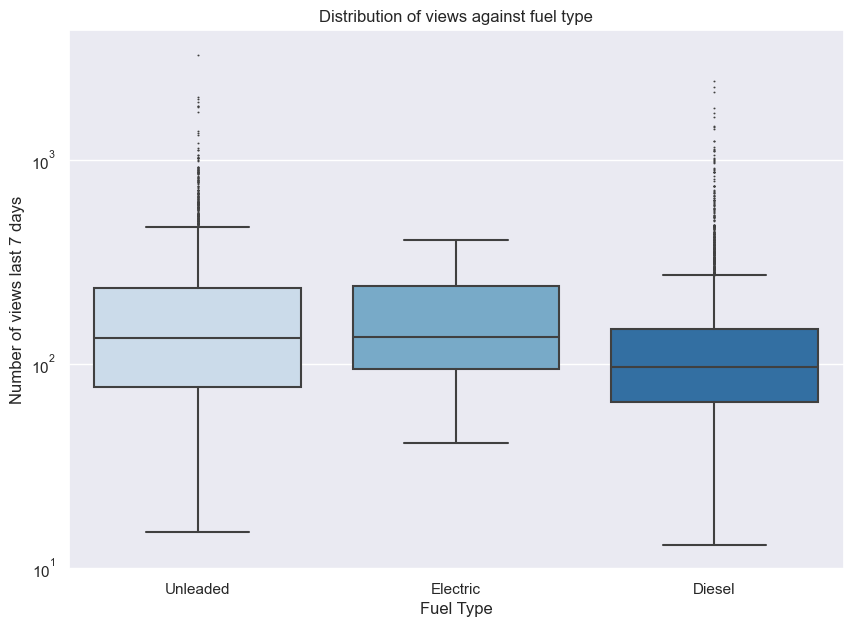

In [34]:
ax = sns.boxplot(data=data, x='Fuel Type', y='Number of views last 7 days', palette="Blues", fliersize=0.5)
ax.set(title='Distribution of views against fuel type')
ax.set(yscale="log")

Gas, Electric and Unleaded are more popular than Diesel.

Let's see if there is a relationship between Condition and our target.

In [35]:
condition_type_mean = pd.DataFrame(data.groupby('Condition')['Number of views last 7 days'].mean().sort_values(ascending=False))

Text(0.5, 0, 'Count')

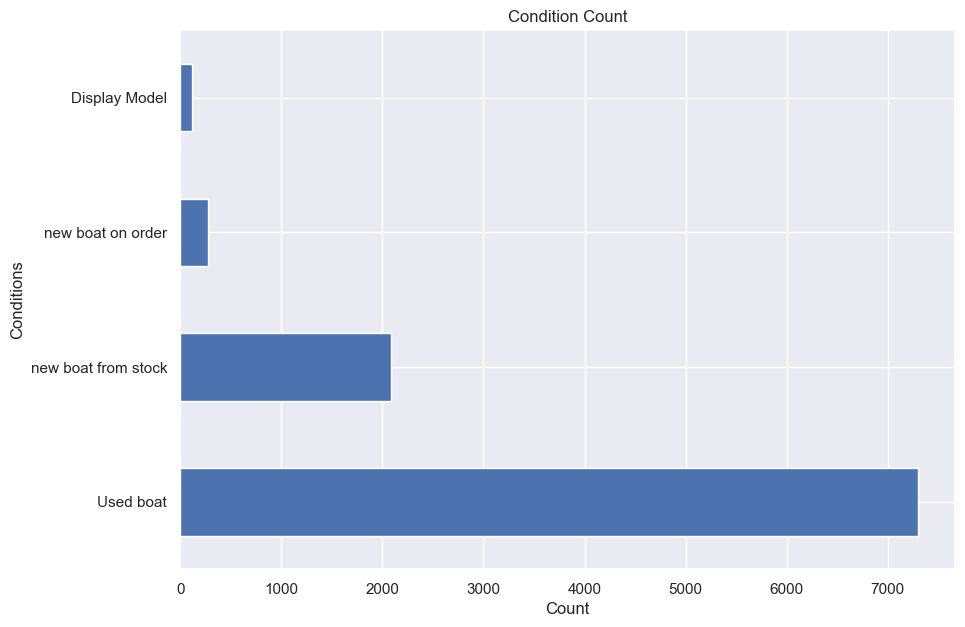

In [36]:
# Let's inspect the Boat Type column
data['Condition'].value_counts().plot.barh()
# Let's inspect the Boat Type column
ax = data['Condition'].value_counts().plot.barh(title='Condition Count')
ax.set_ylabel("Conditions")
ax.set_xlabel("Count")

It would make sense that there are way more used boats than any other kind.

[None]

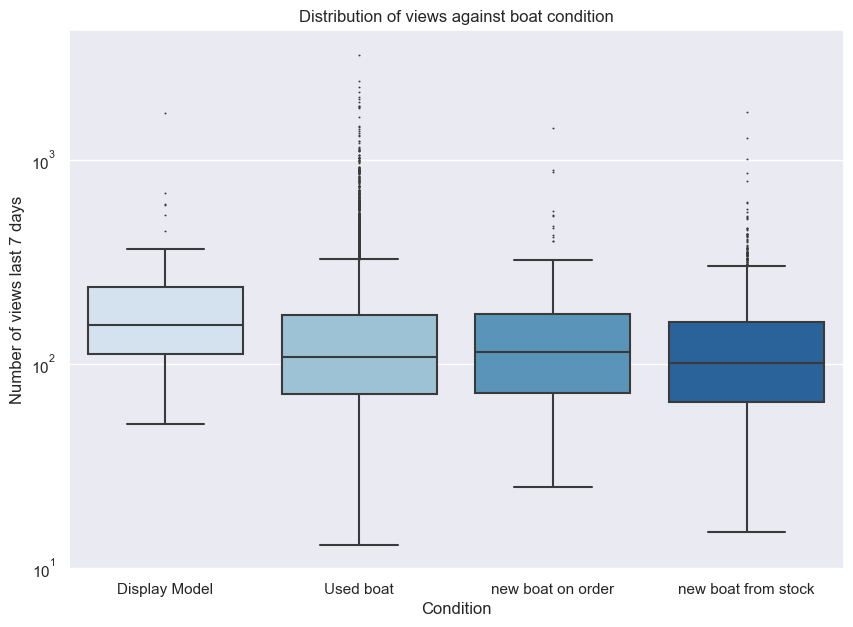

In [37]:
ax = sns.boxplot(data=data, x='Condition', y='Number of views last 7 days', palette="Blues", fliersize=0.5, order=condition_type_mean.index)
ax.set(title='Distribution of views against boat condition')
ax.set(yscale="log")

Display Model is the clear winner here

### Year Built Column

In [38]:
data['Year Built'].value_counts().head()

2020    1276
2019     660
0        550
2008     454
2007     392
Name: Year Built, dtype: int64

There can’t be boats listed that were built in the year 0. This is an error we need to fix.

In [39]:
data['Year Built'] = data['Year Built'].replace({0: np.nan})

Let’s visualize the Year Built distribution

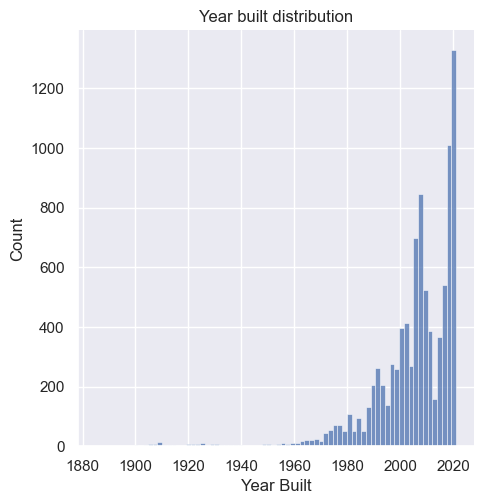

In [40]:
ax = sns.displot(data, x='Year Built')
ax.set(title='Year built distribution')

It seems to be that most boats are fairly new and that there is a large number of boats from 2007-2008 and in recent years.

Let’s group boats by their age and create categories.

In [41]:
data['Age'] = 2022 - data['Year Built']

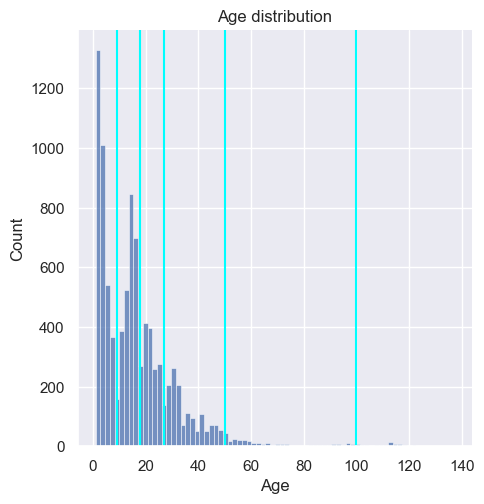

In [42]:
ax = sns.displot(data, x='Age')
ax.set(title='Age distribution')

age_groups = [9, 18, 27, 50, 100]
for x in age_groups:
    plt.axvline(x=x, color='cyan')

age_groups.append(data['Age'].max() + 1)
age_groups.insert(0, data['Age'].min() - 1)

In [43]:
data['Age Category'] = pd.cut(data['Age'], 
                              bins=age_groups,
                              labels=['Very New', 'New', 'Modern', 'Old', 'Very Old', 'Ancient'])

Let's see if there is a relationship between Year Built and our target.

[None]

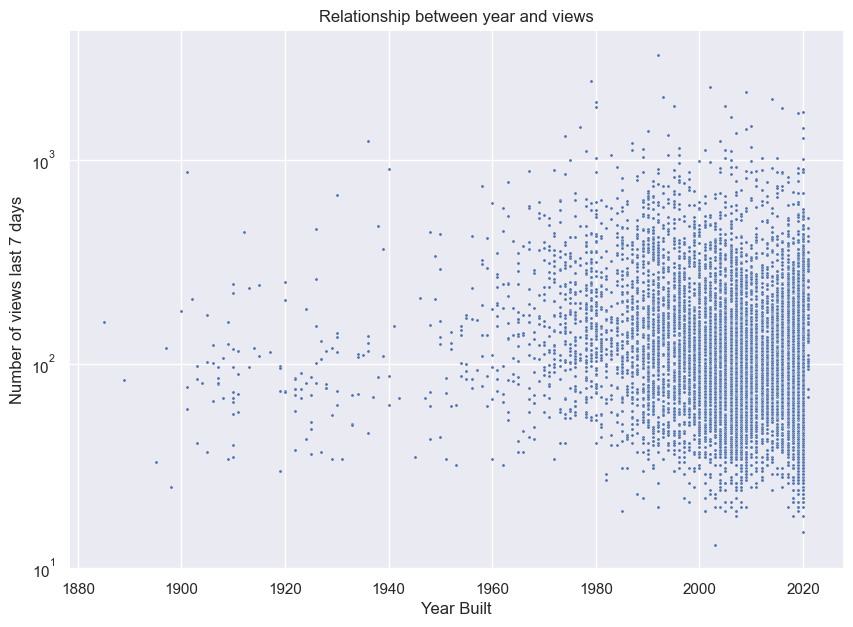

In [44]:
ax = sns.scatterplot(data=data[data['Year Built'].notnull()], x='Year Built', y='Number of views last 7 days', s=5)
ax.set(title='Relationship between year and views')
ax.set(yscale="log")

Visually there isn’t much relationship between Year Built and Number of views last 7 days. The data is too spread out.

### Length Column

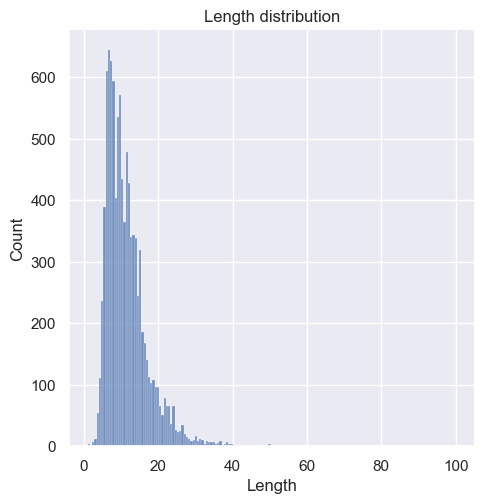

In [45]:
ax = sns.displot(data, x='Length')
ax.set(title='Length distribution')

We can see that most boats in the smaller size. 

Let’s see the descriptive statistics of the Length column.

In [46]:
data['Length'].describe()

count    9849.000000
mean       11.576923
std         6.002744
min         1.040000
25%         7.470000
50%        10.300000
75%        13.930000
max       100.000000
Name: Length, dtype: float64

The average length is around 11 meters.

Let’s analyze the relationship between length and the number of views.

[None]

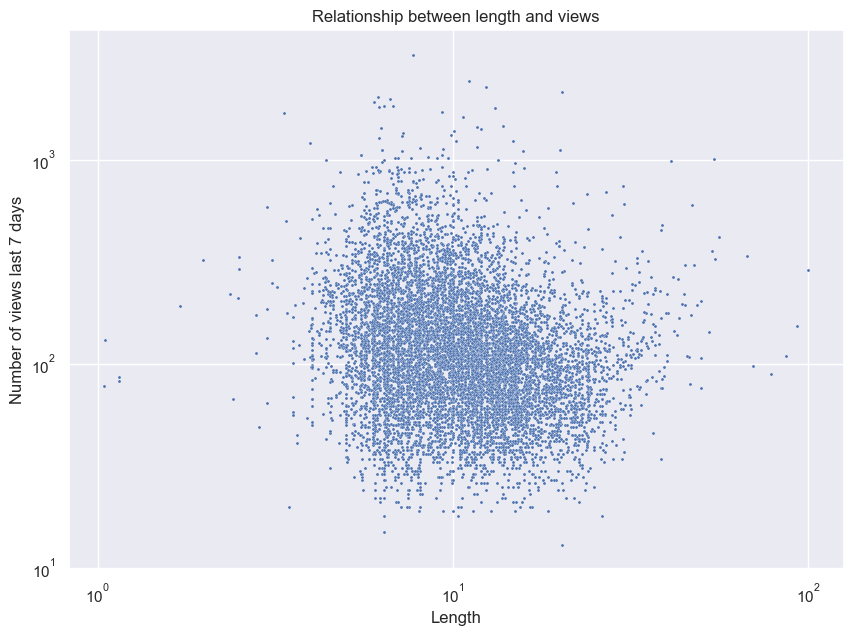

In [47]:
ax = sns.scatterplot(data=data, x='Length', y='Number of views last 7 days', s=5)
ax.set(title='Relationship between length and views')
ax.set(xscale='log')
ax.set(yscale='log')

We do notice that some boats have an unusually short length. Let’s analyze this.

Let’s get all the boats with length under 2 meters.

In [48]:
data[data['Length'] < 2]

,Price,Boat Type,Manufacturer,Year Built,Length,Width,Material,Location,Number of views last 7 days,Currency,Price Category,Condition,Fuel Type,Age,Age Category
3223,1590000,Passenger boat,NaN,1971.0,1.04,11.61,Steel,Netherlands Â» Omgeving Nijmegen,78,EUR,Luxury,Used boat,Diesel,51.0,Very Old
3428,2490000,Passenger boat,NaN,1990.0,1.05,10.15,Steel,Netherlands Â» Omgeving Rotterdam,131,EUR,Luxury,Used boat,Diesel,32.0,Old
4167,460000,Sport Boat,Tecnorib,2020.0,1.70,3.64,NaN,Switzerland Â» Lake Constance Â» Gottlieben,191,EUR,Expensive,new boat on order,Unleaded,2.0,Very New
9373,19320,Center console boat,Bella,NaN,1.98,4.70,GRP,Switzerland Â» VierwaldstÃ¤ttersee Â» Horw,324,CHF,Cheap,Used boat,Unleaded,NaN,NaN
9491,15900,Motor Yacht,NaN,2019.0,1.15,0.50,NaN,Germany Â» Nordrhein-Westfalen Â» Neukirchen-V...,86,EUR,Cheap,Display Model,Electric,3.0,Very New
9660,11900,Motor Yacht,NaN,2019.0,1.15,0.50,NaN,Germany Â» Nordrhein-Westfalen Â» Neukirchen-V...,82,EUR,Cheap,Display Model,Electric,3.0,Very New


Its evident that there were some typing errors on some entries. It is likely that the numeric value of the lengths is correct however the decimal point is in the wrong position. Rather than dropping all these boats with length that do not make so much sense, I believe it would be wiser to drop boats that have their length shorter than their width.

In [49]:
drop_length = data[data['Length'] < data['Width']].index
data = data.drop(drop_length)

### Width Column

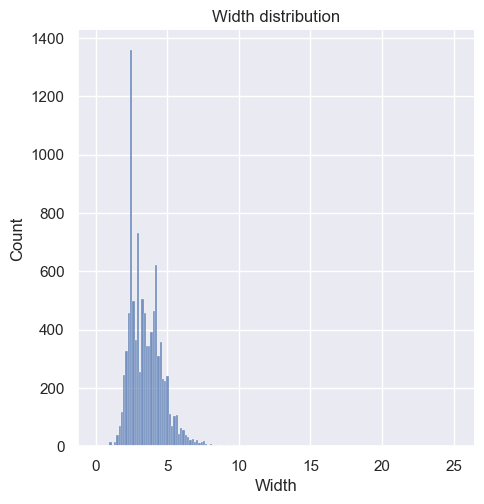

In [50]:
ax = sns.displot(data, x='Width')
ax.set(title='Width distribution')

We notice that the data is slightly more spread out than in the Length column, but nothing unusual.

Let’s see the descriptive statistics of the Width column.

In [51]:
data['Width'].describe()

count    9791.000000
mean        3.515686
std         1.207780
min         0.010000
25%         2.540000
50%         3.330000
75%         4.250000
max        25.160000
Name: Width, dtype: float64

We can see that on average, boats have a width of 3,5 meters.

Let’s analyze the relationship between width and the number of views.

[None]

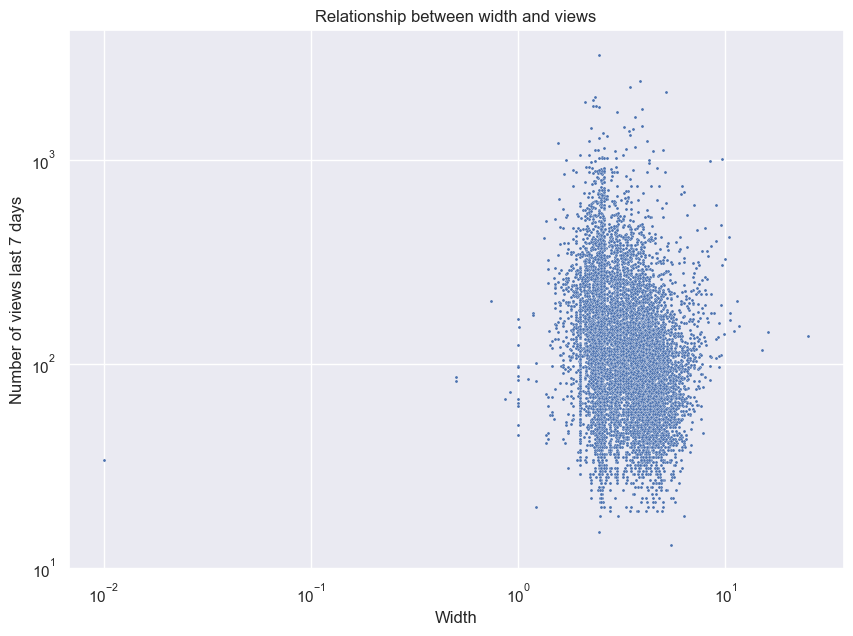

In [52]:
ax = sns.scatterplot(data=data, x='Width', y='Number of views last 7 days', s=5)
ax.set(title='Relationship between width and views')
ax.set(xscale='log')
ax.set(yscale='log')

Just like before, there are some weird values. Let inspect all the rows with very short width.

In [53]:
data[data['Width'] < 1]

,Price,Boat Type,Manufacturer,Year Built,Length,Width,Material,Location,Number of views last 7 days,Currency,Price Category,Condition,Fuel Type,Age,Age Category
2236,175000,Motor Yacht,Sessa,2010.0,11.58,0.91,NaN,Malta Â» San ?iljan,73,EUR,Costly,Used boat,None,12.0,New
3107,812000,Motor Yacht,NaN,2020.0,12.80,0.01,PVC,France,34,EUR,Expensive,new boat from stock,Diesel,2.0,Very New
7216,71982,Pilothouse,Jeanneau,2020.0,2.41,0.86,PVC,"United Kingdom Â» Lincoln, Lincoln",67,GBP,Modest,new boat from stock,None,2.0,Very New
9491,15900,Motor Yacht,NaN,2019.0,1.15,0.50,NaN,Germany Â» Nordrhein-Westfalen Â» Neukirchen-V...,86,EUR,Cheap,Display Model,Electric,3.0,Very New
9604,13579,Cabin Boat,Bayliner,1986.0,7.92,0.74,NaN,"United Kingdom Â» Lincoln, Lincoln",203,GBP,Cheap,Used boat,None,36.0,Old
9660,11900,Motor Yacht,NaN,2019.0,1.15,0.50,NaN,Germany Â» Nordrhein-Westfalen Â» Neukirchen-V...,82,EUR,Cheap,Display Model,Electric,3.0,Very New


Asides from some few exceptions (mostly recreational boats) it’s highly unlikely that boats have a width narrower than 1 meter. A simple solution would be to drop these values; however, I believe that it would be wiser to drop values whose width to length ration is unreasonable.

In [54]:
drop_width = data[(data['Length'] / data['Width'] > 11) | (data['Length'] / data['Width'] < 1.4)].index
data = data.drop(drop_width)

### Material Column

In [55]:
data['Material'].value_counts()

GRP                    5448
PVC                    1118
Steel                   933
Wood                    235
Aluminium               229
Plastic                  76
Carbon Fiber             29
Thermoplastic            15
Hypalon                   5
Reinforced concrete       1
Rubber                    1
Name: Material, dtype: int64

Some materials have very few entries. Let’s drop these rows.

In [56]:
drop_material = ['Rubber', 'Hypalon', 'Reinforced concrete', 'Hypalon', 'Thermoplastic']
data = data[~data['Material'].isin(drop_material)]

Text(0.5, 0, 'Count')

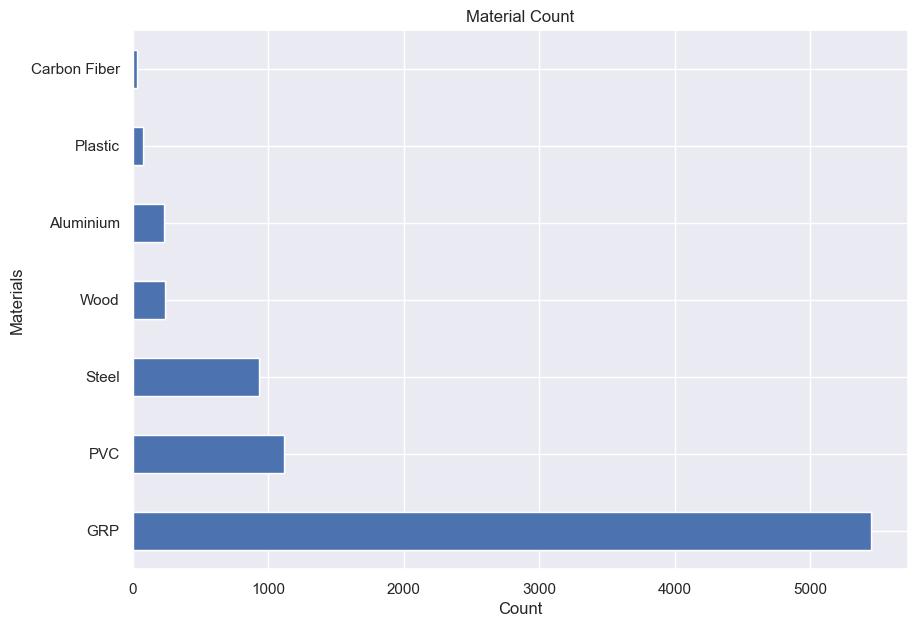

In [57]:
# Let's inspect the Boat Type column
data['Material'].value_counts().plot.barh()
# Let's inspect the Boat Type column
ax = data['Material'].value_counts().plot.barh(title='Material Count')
ax.set_ylabel("Materials")
ax.set_xlabel("Count")

By far, GRP is the most common material in this website.

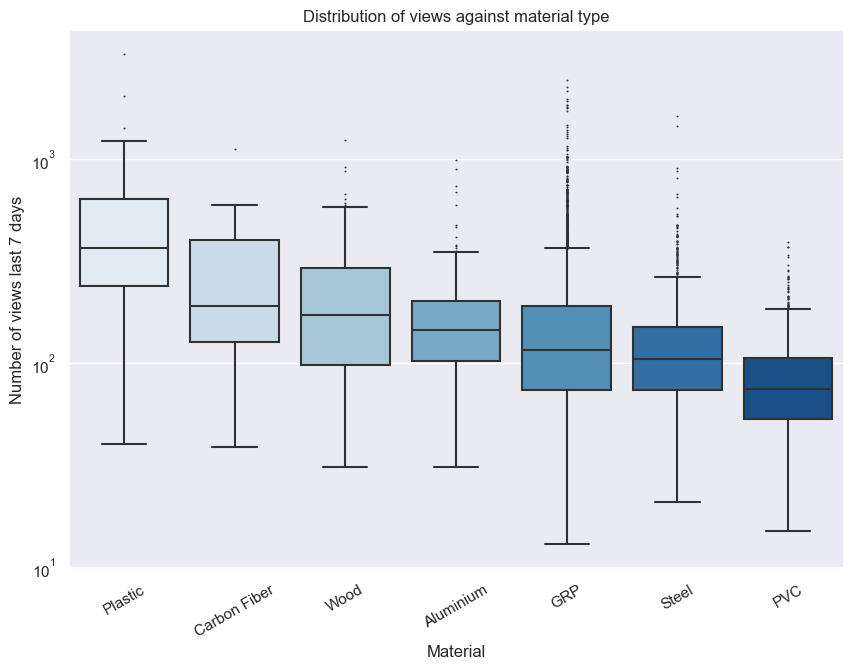

In [58]:
material_type_mean = pd.DataFrame(data.groupby('Material')['Number of views last 7 days'].mean().sort_values(ascending=False))
ax = sns.boxplot(data=data, x='Material', y='Number of views last 7 days', palette="Blues", fliersize=0.5, order=material_type_mean.index)
ax.set(title='Distribution of views against material type')
ax.set(yscale="log")
ax.tick_params(axis='x', rotation=30)

Plastic is clearly the most popular material.

### Location Column

In [59]:
data['Location'].head()

0        Switzerland Â» Lake Geneva Â» VÃ©senaz
2    Switzerland Â» Lake of Zurich Â» StÃ¤fa ZH
3                          Denmark Â» Svendborg
4                 Germany Â» Bayern Â» MÃ¼nchen
5       Switzerland Â» Lake Constance Â» Uttwil
Name: Location, dtype: object

It’s going to be easier if we only worked with the countries/regions rather than specific locations. Let’s first start by fixing the encoding issue and then extracting the country/region from each entry.

In [60]:
# Fixing encoding
data['Location'] = data_copy['Location'].apply(re_encode)

# Extracting country/location
data['Location'] = data['Location'].str.split('»').str[0].str.strip()

# Parsing NaN values and renaming Croatia
country_dict = {
    'Croatia (Hrvatska)': 'Croatia',
    'nan': np.nan,
}

data['Location'] = data['Location'].replace(country_dict)

Lets visualize how the most popular countries relate to the Number of views last 7 days.

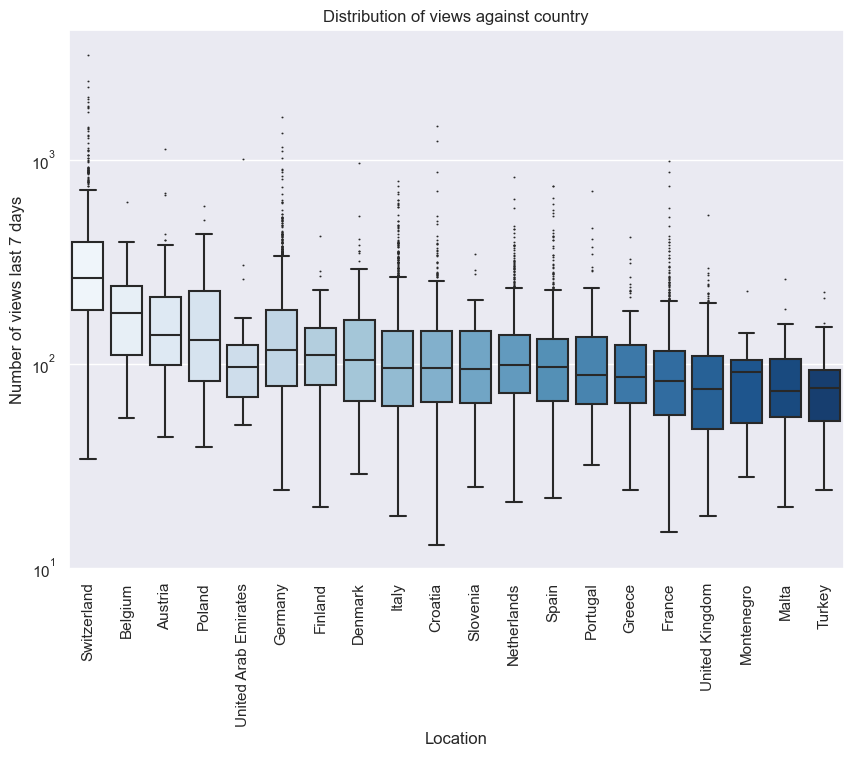

In [61]:
most_frequent_location = data['Location'].value_counts().head(20).index
location_mean = pd.DataFrame(data[data['Location'].isin(most_frequent_location)].groupby('Location')['Number of views last 7 days'].mean().sort_values(ascending=False))

ax = sns.boxplot(data=data[data['Location'].isin(most_frequent_location)], x='Location', y='Number of views last 7 days', palette="Blues", fliersize=0.5, order=location_mean.index)
ax.set(title='Distribution of views against country')
ax.set(yscale="log")
ax.tick_params(axis='x', rotation=90)

Just like in the case of currency, Switzerland is the most popular country.

It's evident that most entries are in Europe, lets visualize the data.

(35.0, 60.0)

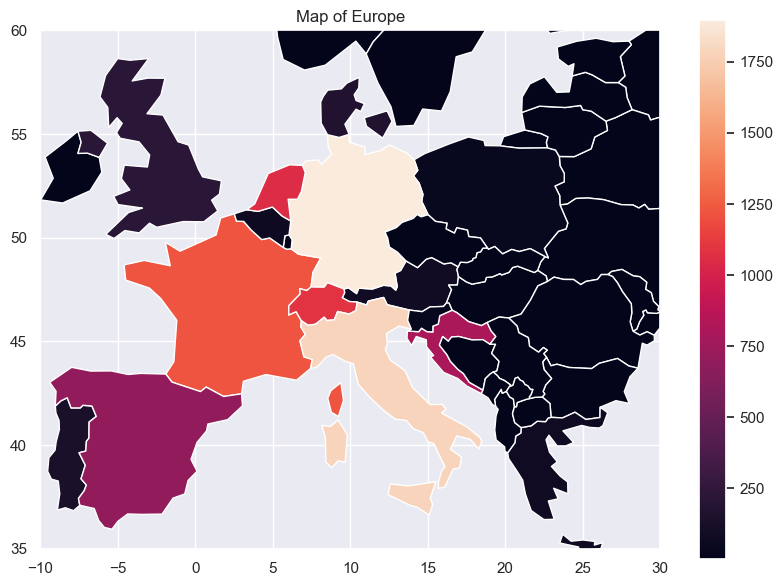

In [62]:
country_subset = pd.DataFrame(data['Location'].value_counts()).reset_index()
country_subset.rename(columns = {'index': 'name', 'Location': 'frequency'}, inplace=True)
country_subset.head()

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world.merge(country_subset, on='name', how='left')
world = world.fillna(1)

ax = world[world['continent'] == 'Europe'].plot(column='frequency', legend=True)
ax.set(title='Map of Europe')
plt.xlim([-10,30])
plt.ylim([35,60])

We can infer from this map that Germany and Italy both have the most amount of boat listings.

### Number of views last 7 days Column

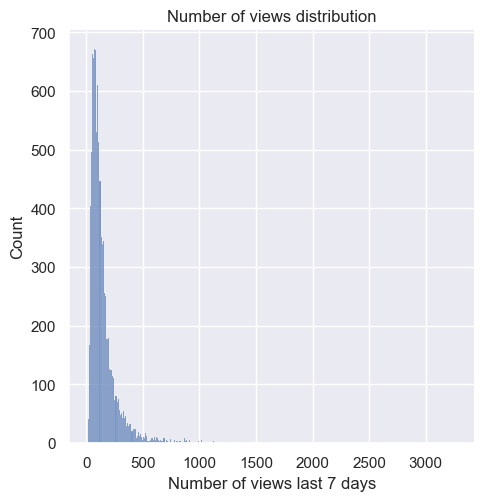

In [63]:
ax = sns.displot(data, x='Number of views last 7 days')
ax.set(title='Number of views distribution')

The data is very skewed, lets visualize it in a different scale and create view categories.

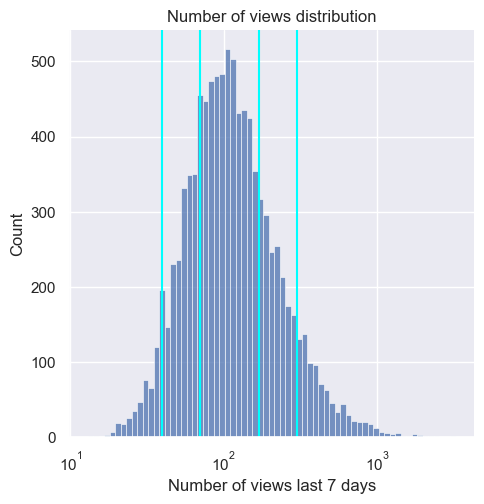

In [64]:
ax = sns.displot(data, x='Number of views last 7 days', log_scale=True)
ax.set(title='Number of views distribution')

view_category = [40, 70, 170, 300]
for x in view_category:
    plt.axvline(x=x, color='cyan')

view_category.append(data['Number of views last 7 days'].max() + 1)
view_category.insert(0, data['Number of views last 7 days'].min() - 1)

In [65]:
data['View Category'] = pd.cut(data['Number of views last 7 days'], 
                              bins=view_category,
                              labels=['Very Unpopular', 'Unpopular', 'Average', 'Popular', 'Very Popular'])

In [66]:
data['Number of views last 7 days'].describe()

count    9804.000000
mean      148.687780
std       150.997119
min        13.000000
25%        70.000000
50%       107.000000
75%       171.000000
max      3263.000000
Name: Number of views last 7 days, dtype: float64

We can see that on average there are 150 views per boat however the mean value is much lower. It is 100.

Let’s see which was the most popular and least popular boat.

In [67]:
data[data['Number of views last 7 days'] == data['Number of views last 7 days'].max()]

,Price,Boat Type,Manufacturer,Year Built,Length,Width,Material,Location,Number of views last 7 days,Currency,Price Category,Condition,Fuel Type,Age,Age Category,View Category
9580,14466,Motor Yacht,Bayliner,1992.0,7.7,2.46,Plastic,Switzerland,3263,CHF,Cheap,Used boat,Unleaded,30.0,Old,Very Popular


In [68]:
data[data['Number of views last 7 days'] == data['Number of views last 7 days'].min()]

,Price,Boat Type,Manufacturer,Year Built,Length,Width,Material,Location,Number of views last 7 days,Currency,Price Category,Condition,Fuel Type,Age,Age Category,View Category
3982,580000,Motor Yacht,Dominator,2003.0,20.3,5.5,GRP,Croatia,13,EUR,Expensive,Used boat,Diesel,19.0,Modern,Very Unpopular


# <span style="color:#0066CC">Exploratory Data Analysis</span>
After having cleaned up the data and visualizing some relationships, let’s answer some questions.

### Does the price impact the number of views?

We previously saw from the scatterplot that there wasn’t so much of a correlation between price and views. Let’s calculate the correlation to prove this points.

In [69]:
print(f"Correlation between price and views: {data['Price'].corr(data['Number of views last 7 days'])}")

Correlation between price and views: -0.007631263480475292


However, we did divide our prices into groups, lets check if those groups make a difference.

[Text(0.5, 1.0, 'Distribution of views against price category')]

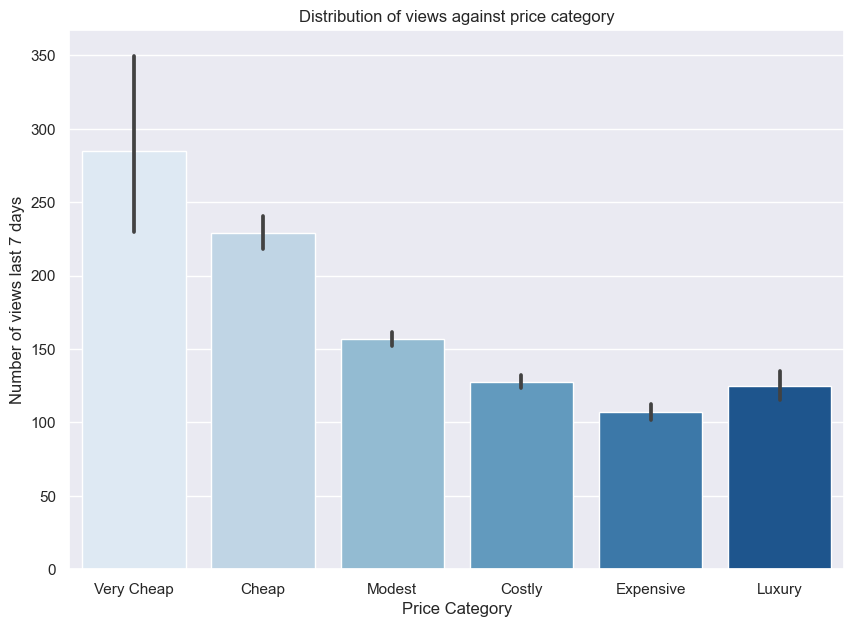

In [70]:
ax = sns.barplot(data=data, x='Price Category', y='Number of views last 7 days', palette="Blues")
ax.set(title='Distribution of views against price category')

There is a clear difference. People are much more interested in Cheap and Very Cheap boats. This makes sense since boats aren’t so affordable.

### Does the age of the boat impact the number of views?

Let’s visualize the relationship between age category and the number of views.

[Text(0.5, 1.0, 'Distribution of views against age category')]

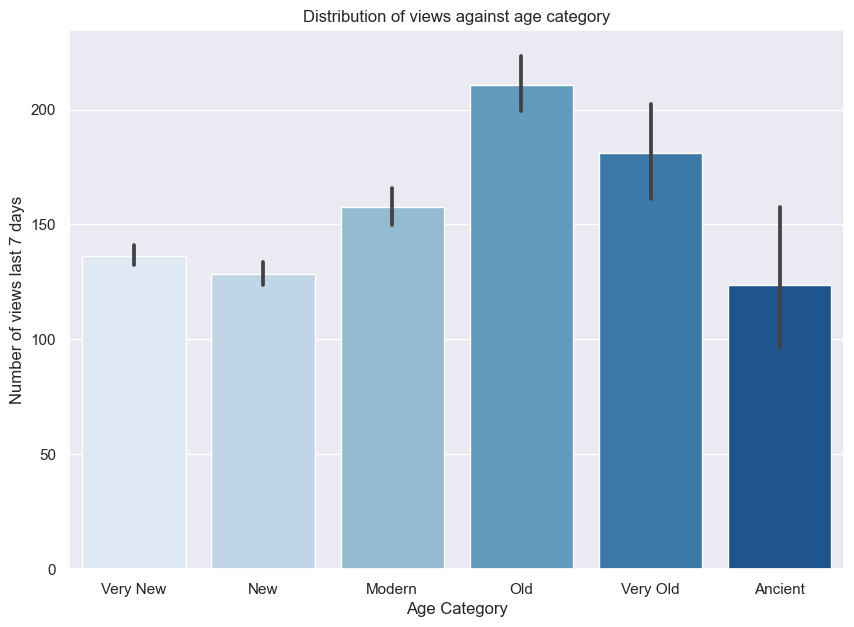

In [71]:
ax = sns.barplot(data=data, x='Age Category', y='Number of views last 7 days', palette="Blues")
ax.set(title='Distribution of views against age category')

Old boats are much more popular than their new counterparts. It would make sense then if the old boats were the cheapest. Let’s verify this.

[Text(0.5, 1.0, 'Distribution of price against age category')]

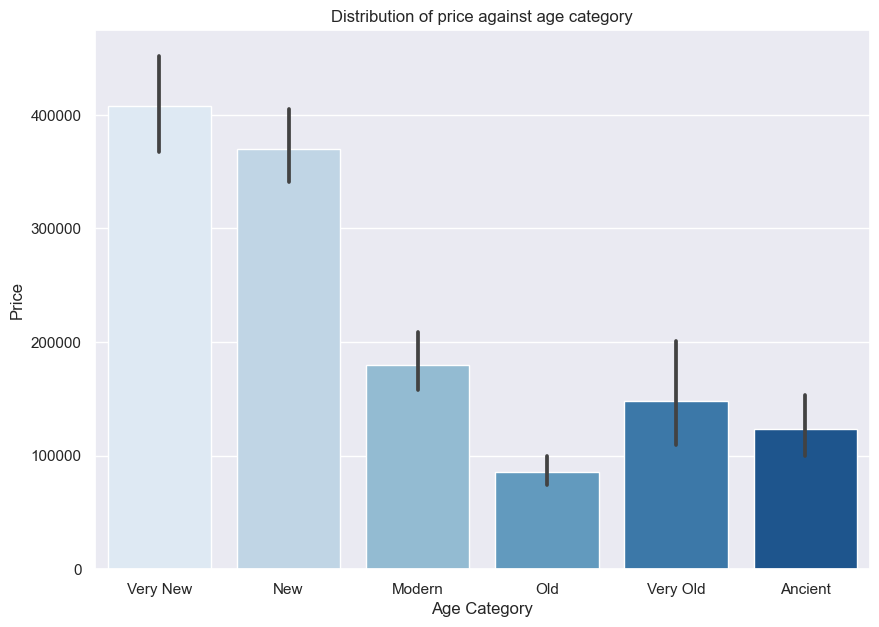

In [72]:
ax = sns.barplot(data=data, x='Age Category', y='Price', palette="Blues")
ax.set(title='Distribution of price against age category')

As expected, old boats are the cheapest.

### Does the length of the boat impact the number of views?

[Text(0.5, 1.0, 'Distribution of length against view category')]

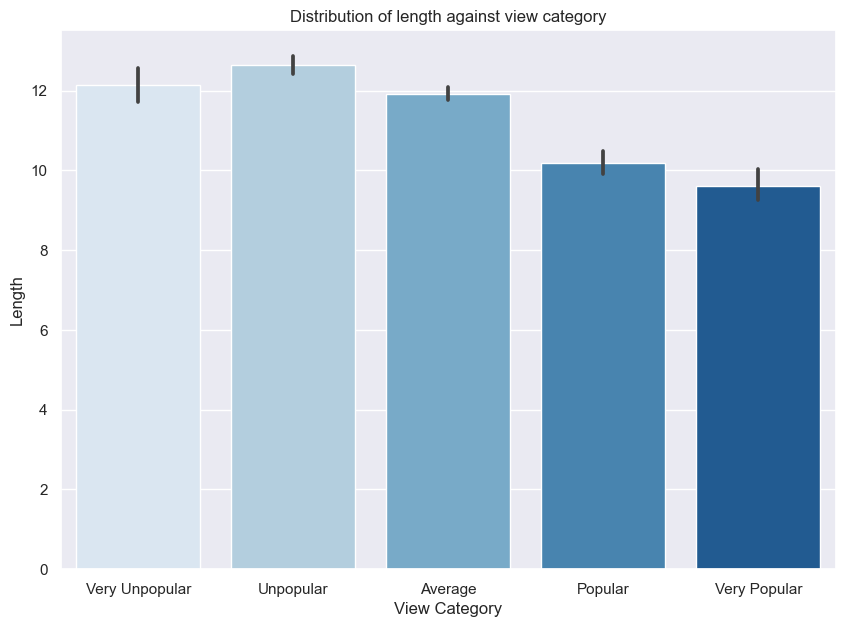

In [73]:
ax = sns.barplot(data=data, x='View Category', y='Length', palette="Blues")
ax.set(title='Distribution of length against view category')

Although not as conclusive, smaller boats are more popular.

### Are different countries interested in different boat ages?

Let’s focus on the most relevant countries, in other words, lets work with the top 7 countries by count.

In [74]:
# Getting the top 7 countries by count
frequent_countries = data['Location'].value_counts().head(7).index

# Let's copy the DataFrame
country_df = data.copy()

# Replace countries not in list with 'Other'
country_df.loc[~country_df["Location"].isin(frequent_countries), "Location"] = "Other"

[Text(0.5, 1.0, 'Number of views per age category and country')]

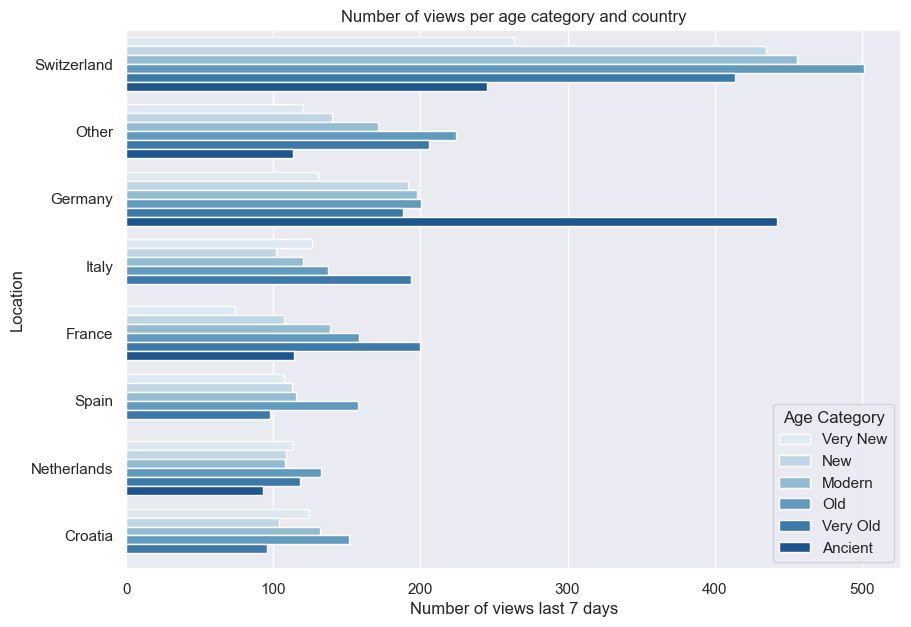

In [75]:
ax = sns.barplot(data=country_df, x='Number of views last 7 days', y='Location', hue='Age Category', ci=False, palette="Blues")
ax.set(title='Number of views per age category and country')

As expect, old boats are the most popular, regardless of the country. We do notice however that there is a lot of interest for ancient boats in Germany, this could be caused by outliers. Let’s further inspect this.

In [76]:
country_df[(country_df['Location'] == 'Germany') & (country_df['Age Category'] == 'Ancient')]

,Price,Boat Type,Manufacturer,Year Built,Length,Width,Material,Location,Number of views last 7 days,Currency,Price Category,Condition,Fuel Type,Age,Age Category,View Category
172,12500,Trawler,Schlosswerft,1913.0,14.7,3.65,Steel,Germany,235,EUR,Cheap,Used boat,Diesel,109.0,Ancient,Popular
2191,169000,House Boat,Katwijker,1910.0,23.0,4.80,Steel,Germany,222,EUR,Costly,Used boat,Diesel,112.0,Ancient,Popular
6703,89000,Classic,van de Werf,1901.0,11.0,3.00,Steel,Germany,868,EUR,Modest,Used boat,Diesel,121.0,Ancient,Very Popular
8156,45000,Cabin Boat,Yachtwerft Berlin,1912.0,15.0,3.50,Steel,Germany,444,EUR,Modest,Used boat,Diesel,110.0,Ancient,Very Popular


We notice the following, there are very few entries in this group and, there is a very popular boat that makes the average increase. There isn’t sufficient data to conclude that ancient boats are the most popular age category in Germany.

### Are different countries interested in different price groups?

Just like before, lets focus on the top 7 countries.

[Text(0.5, 1.0, 'Number of views per price category and country')]

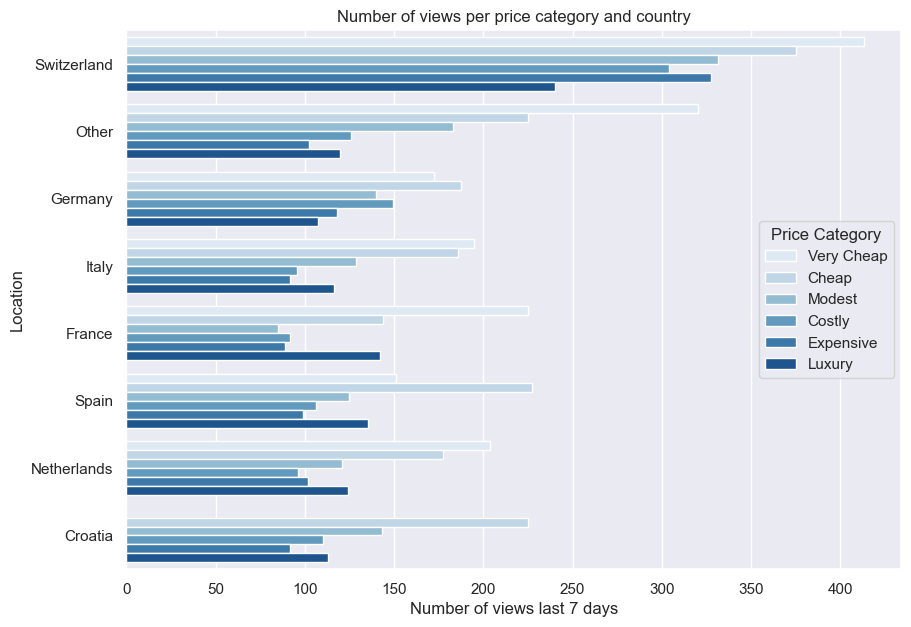

In [77]:
ax = sns.barplot(data=country_df, x='Number of views last 7 days', y='Location', hue='Price Category', ci=False, palette="Blues")
ax.set(title='Number of views per price category and country')

The countries seem to behave almost in the same manner, very cheap and cheap boats are the most viewed categories.

### Are different countries interested in different boat types?

In [78]:
# Getting the 7 most common boat types
frequent_types = data['Boat Type'].value_counts().head(7).index

# Let's copy the DataFrame
type_df = country_df.copy()

# Subset these common boat types
type_df = type_df[type_df['Boat Type'].isin(frequent_types)]

[Text(0.5, 1.0, 'Number of views per price category and country')]

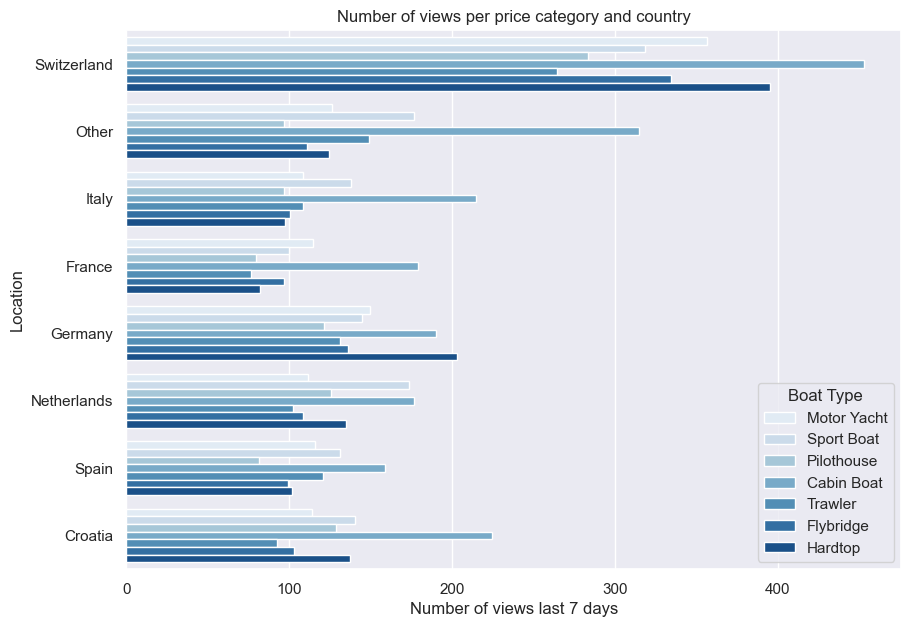

In [79]:
ax = sns.barplot(data=type_df, x='Number of views last 7 days', y='Location', hue='Boat Type', ci=False, palette="Blues")
ax.set(title='Number of views per price category and country')

Every country seems to behave almost in the same way. In all countries, cabin boats are the most popular type.

### Are different countries interested in different boat manufacturers?

Since there are hundred of manufacturers, lets focus on the 7 most common ones.

In [80]:
# Getting the 7 most common manufacturers
frequent_manufacturer = data['Manufacturer'].value_counts().head(7).index

# Let's copy the DataFrame
manufacturer_df = country_df.copy()

# Subset these common boats
manufacturer_df = manufacturer_df[manufacturer_df['Manufacturer'].isin(frequent_manufacturer)]

[Text(0.5, 1.0, 'Number of views per price category and country')]

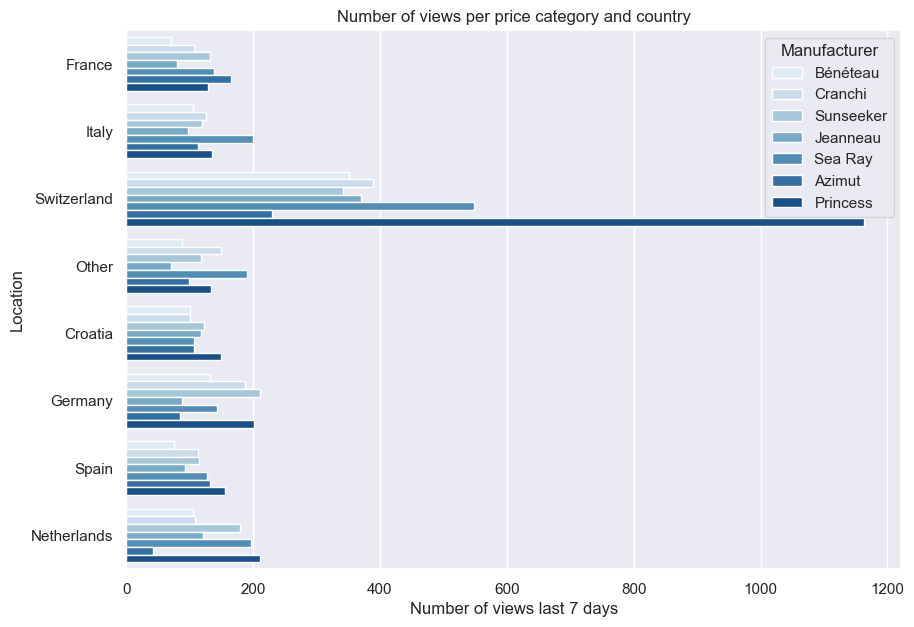

In [81]:
ax = sns.barplot(data=manufacturer_df, x='Number of views last 7 days', y='Location', hue='Manufacturer', ci=False, palette="Blues")
ax.set(title='Number of views per price category and country')

In most countries, Sea Ray and Princess are the most popular boat brands.

Princess boats in Switzerland seem to be exceptionally high, lets inspect this.

In [82]:
data[(data['Manufacturer'] == 'Princess') & (data['Location'] == 'Switzerland')]

,Price,Boat Type,Manufacturer,Year Built,Length,Width,Material,Location,Number of views last 7 days,Currency,Price Category,Condition,Fuel Type,Age,Age Category,View Category
6748,89320,Motor Yacht,Princess,1995.0,11.76,3.86,GRP,Switzerland,263,CHF,Modest,Used boat,Diesel,27.0,Modern,Popular
7654,60194,Flybridge,Princess,1990.0,9.39,3.40,GRP,Switzerland,660,CHF,Modest,Used boat,Unleaded,32.0,Old,Very Popular
8723,33980,Hardtop,Princess,1979.0,11.12,3.88,GRP,Switzerland,2432,CHF,Modest,Used boat,Diesel,43.0,Old,Very Popular
9877,4854,Cabin Boat,Princess,1974.0,7.20,2.70,GRP,Switzerland,1299,CHF,Very Cheap,Used boat,None,48.0,Old,Very Popular


There are only four data entries in which one boat is exceptionally popular. There isn’t sufficient data to conclude that Princess boats in Switzerland are the most popular boat manufacturer.

### Are different countries interested in different boat conditions?

[Text(0.5, 1.0, 'Number of views per price category and country')]

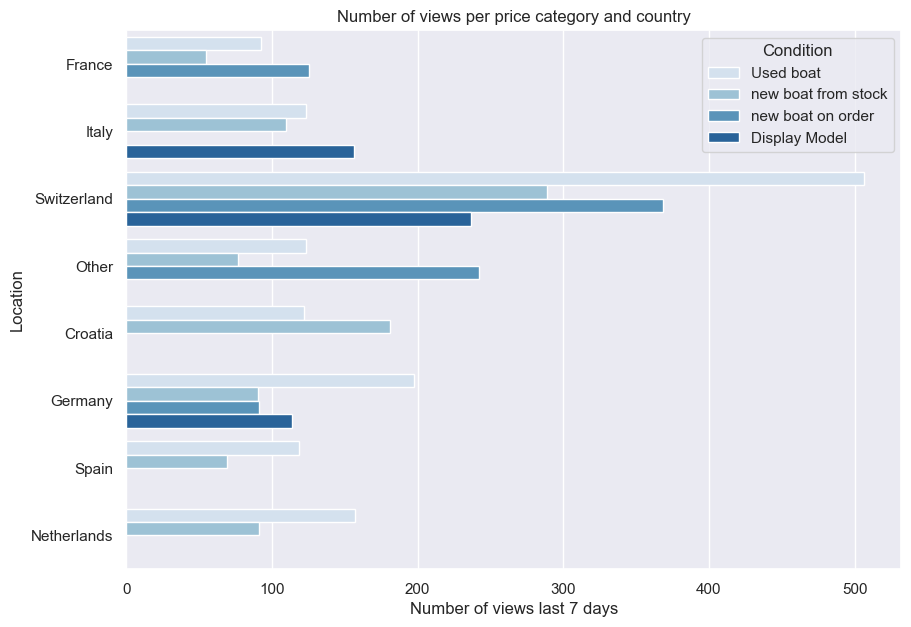

In [83]:
ax = sns.barplot(data=manufacturer_df, x='Number of views last 7 days', y='Location', hue='Condition', ci=False, palette="Blues")
ax.set(title='Number of views per price category and country')

Used boats, especially in Switzerland are popular.

### Price group analysis

It's apparent that the price group is a very relevant feature. Let’s finish by analyzing which are the cheapest boat manufacturers, materials, manufacturers, fuel type and condition.

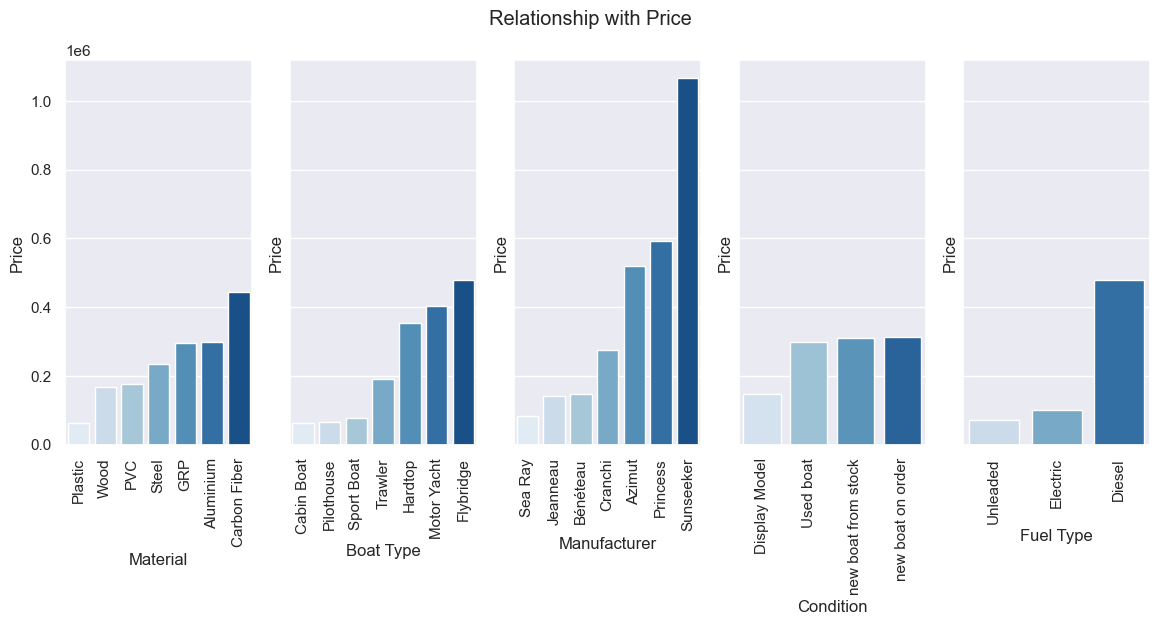

In [84]:
# Creating an order for each category
material_order = data.groupby('Material')['Price'].mean().sort_values(ascending=True).index
boat_order = type_df.groupby('Boat Type')['Price'].mean().sort_values(ascending=True).index
manufacturer_order = manufacturer_df.groupby('Manufacturer')['Price'].mean().sort_values(ascending=True).index
condition_order = data.groupby('Condition')['Price'].mean().sort_values(ascending=True).index

# Plotting
fig, axes = plt.subplots(1, 5, figsize=(14, 5), sharey=True) 
fig.suptitle('Relationship with Price')
 
sns.barplot(ax=axes[0], data=data, x='Material', y='Price', ci=False, palette="Blues", order=material_order)
sns.barplot(ax=axes[1], data=type_df, x='Boat Type', y='Price', ci=False, palette="Blues", order=boat_order)
sns.barplot(ax=axes[2], data=data, x='Manufacturer', y='Price', ci=False, palette="Blues", order=manufacturer_order)
sns.barplot(ax=axes[3], data=data, x='Condition', y='Price', ci=False, palette="Blues", order=condition_order)
sns.barplot(ax=axes[4], data=data, x='Fuel Type', y='Price', ci=False, palette="Blues")

axes[0].tick_params(axis='x', rotation=90)
axes[1].tick_params(axis='x', rotation=90)
axes[2].tick_params(axis='x', rotation=90)
axes[3].tick_params(axis='x', rotation=90)
axes[4].tick_params(axis='x', rotation=90)

We can clearly see that plastic boats, cabin boats and Sea Ray are the cheapest types of boats as well as display model and unleaded. Considering our previous findings, this makes sense.

### Conclusion

After analyzing and visualizing each variable in the dataset, we can say that for the most part, the results are aligned with what we would expect.
If the product manager intends on boosting traffic on the website, the following measures should be taken:
* The company should mainly focus on cheaper boats, they bring the greatest number of views in almost every country. 
* Old boats are cheaper and thus they bring lots of views
* Boats from Europe and especially Switzerland should be the company’s main priority when advertising. Switzerland is by far the country that brings in the greatest number of views. 
* Cabin boats have the highest average views, regardless of the country in which we are located
* Used boats especially in Switzerland have a very high demand. This makes sense since used boats are cheaper.
* Smaller boats bring in more views

# <span style="color:#0066CC">Imputing missing data</span>

Before we begin with our model, we need to address the missing values. 

The simplest approach would be dropping all missing data. Let’s check this out.

In [85]:
# Count the amount of rows in the original dataset
rows_with_na = data.shape[0]

# Dropping all NaN from the dataset and counting the number of rows
data_no_na = data.dropna()
rows_no_na = data_no_na.shape[0]

print(f'Available rows after dropping NaN: {int(rows_no_na * 100 / rows_with_na)}%')

Available rows after dropping NaN: 55%


We can see that roughly half of the dataset is lost. This isn’t acceptable. We should try to impute some values. Let’s inspect the missing values first.

<AxesSubplot:>

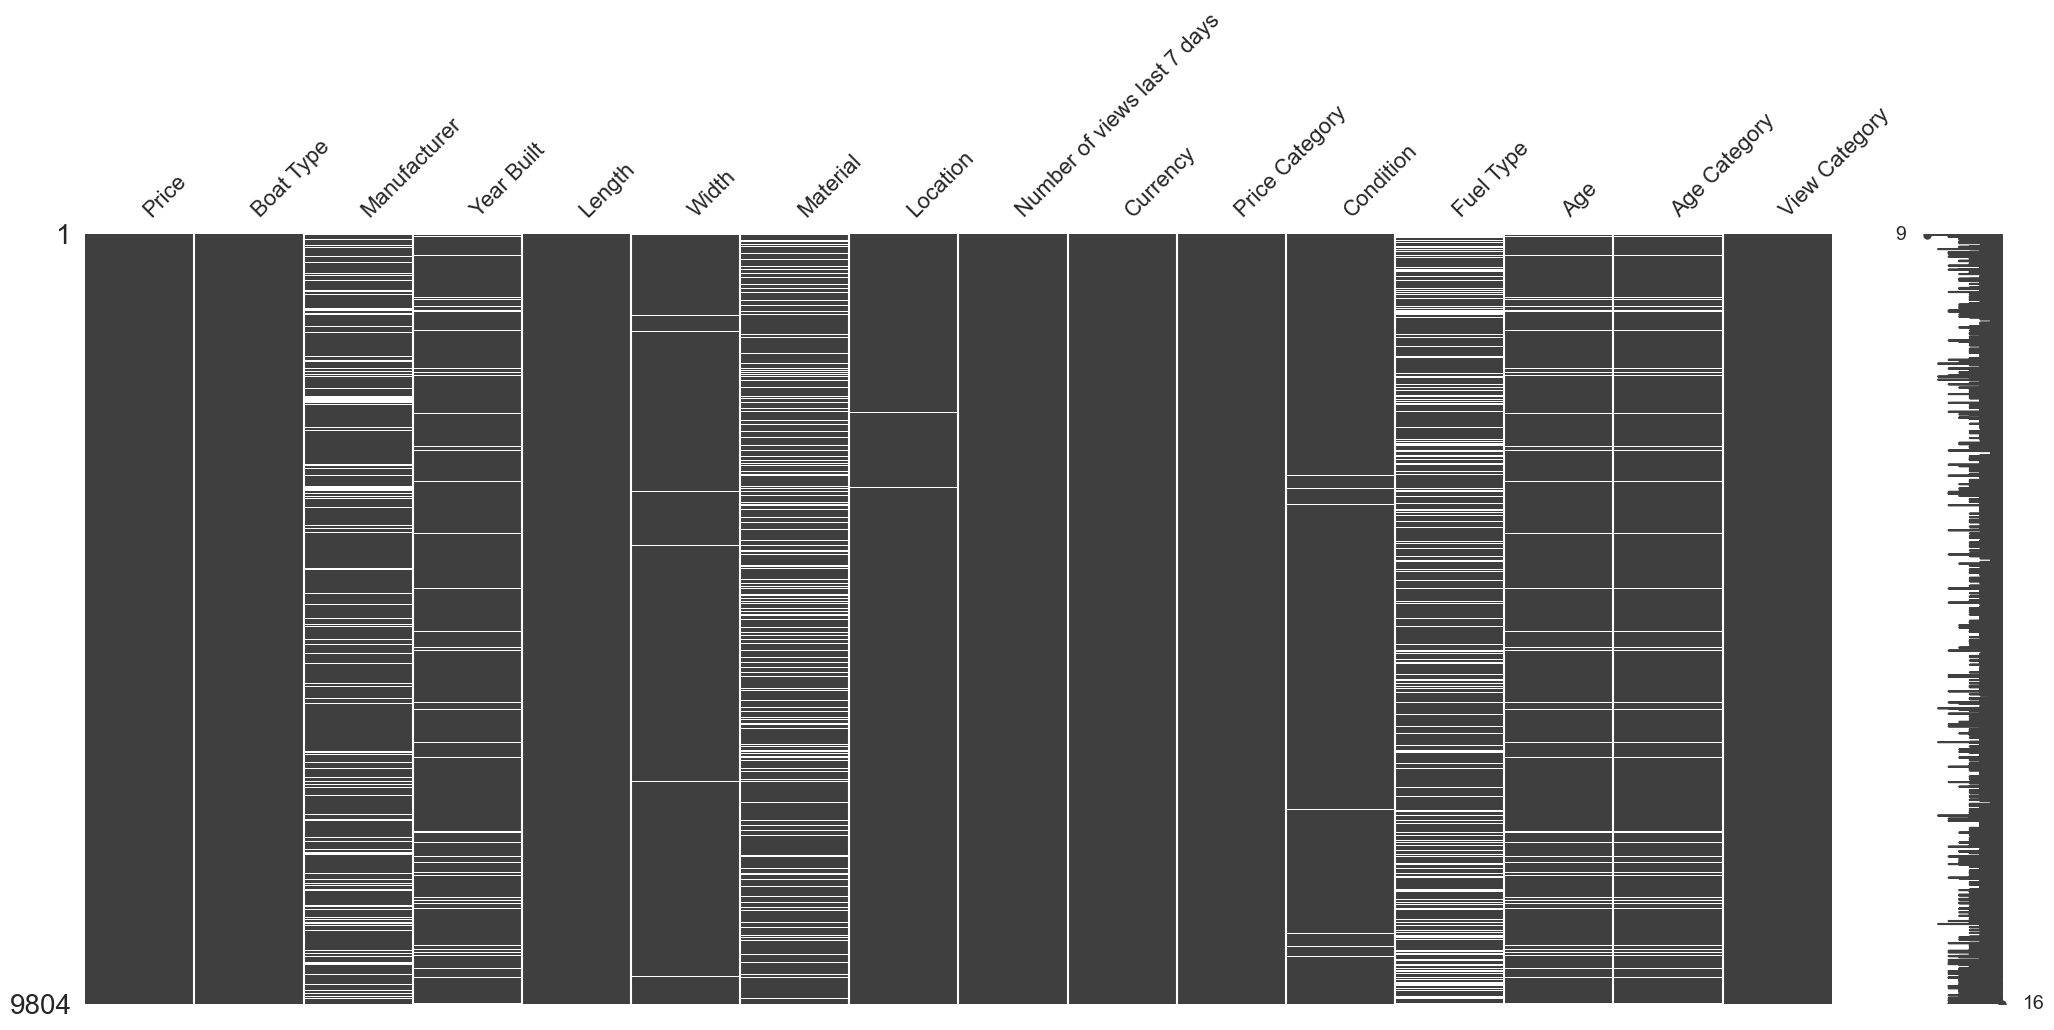

In [86]:
msno.matrix(data)

In [87]:
data.isnull().sum()

Price                             0
Boat Type                         0
Manufacturer                   1325
Year Built                      546
Length                            8
Width                            55
Material                       1736
Location                         34
Number of views last 7 days       0
Currency                          0
Price Category                    0
Condition                        85
Fuel Type                      2194
Age                             546
Age Category                    546
View Category                     0
dtype: int64

We see that Manufacturer, Material and Fuel Type are the most compromised columns. Let’s fix these.

There isn’t much we can do to the **Manufacturer column**. There are hundreds of manufacturers and in my opinion, imputing this column doesn’t make sense. I believe the wisest option is to simply drop all NaN from this column. The same applies to the **Location column**.

In [88]:
imputed_data = data[data['Manufacturer'].notna()]
imputed_data = imputed_data[imputed_data['Location'].notna()]

With regards to the **Fuel Type column**, as we previously saw, the more expensive boats tend to be diesel powered. Although we have 4 fuel types, electric and gas powered boats have very few entries so lets just focus on diesel and unleaded. Let’s make that all boats below the 50% quantile in price are unleaded and boats above the 50% quantile are diesel.

In [89]:
fuel_threshold = imputed_data[imputed_data['Fuel Type'].isna()]['Price'].quantile(0.5)

imputed_data.loc[(imputed_data['Price'] >= fuel_threshold) & (imputed_data['Fuel Type'].isna()), 'Fuel Type'] = 'Diesel'
imputed_data.loc[(imputed_data['Price'] < fuel_threshold) & (imputed_data['Fuel Type'].isna()), 'Fuel Type'] = 'Unleaded'

Imputing the **Materials column** is a bit more difficult than the fuel column since there are many types of materials. I believe that imputing by age group is the best way. However, lets only focus on the common material types, that is GRP, PVC, and Steel.

In [90]:
data.groupby('Material')['Age'].quantile(0.5)

Material
Aluminium        3.0
Carbon Fiber    11.5
GRP             14.0
PVC              7.0
Plastic         21.5
Steel           30.0
Wood            43.0
Name: Age, dtype: float64

If the age category is very new, let's make it PVC. If its new let's, make it GRP. Modern is Steel and very old is Wood. This will, however, leave some unassigned rows.

In [91]:
imputed_data.loc[(imputed_data['Age Category'] == 'Very New') & (imputed_data['Material'].isna()), 'Material'] = 'PVC'
imputed_data.loc[(imputed_data['Age Category'] == 'New') & (imputed_data['Material'].isna()), 'Material'] = 'GRP'
imputed_data.loc[(imputed_data['Age Category'] == 'Modern') & (imputed_data['Material'].isna()), 'Material'] = 'Steel'
imputed_data.loc[(imputed_data['Age Category'] == 'Very Old') & (imputed_data['Material'].isna()), 'Material'] = 'Wood'

# Let's drop the unassigned rows
imputed_data = imputed_data[imputed_data['Material'].notna()]

Let’s now impute the **Length column**. Fortunately, there aren’t many values we need to estimate. We are going to use the Price column to help us estimate the lengths of boats. Let's visualize their relationship.

[None]

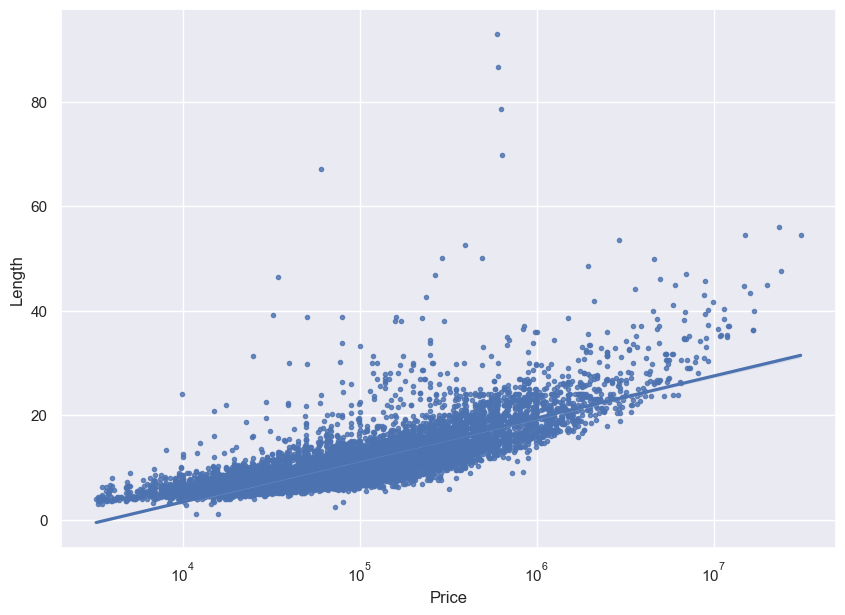

In [92]:
ax = sns.regplot(data=data, x='Price', y='Length', marker='.', logx=True)
ax.set(xscale="log")

We can clearly see that there is a logarithmic relationship between price and length. Let’s fit a curve and impute our missing values. 
$ y = c_1 . log(x) + c_2$

In [93]:
curve = np.polyfit(np.log(data_no_na['Price']), data_no_na['Length'], 1)
impute_length_function = lambda x: curve[0]*np.log(x) + curve[1] 

imputed_data.loc[imputed_data['Length'].isnull(), 'Length'] = impute_length_function(imputed_data['Price'])

The **Width column** and Length column are highly related. The longer the boat the wider it is. Let’s visualize this.

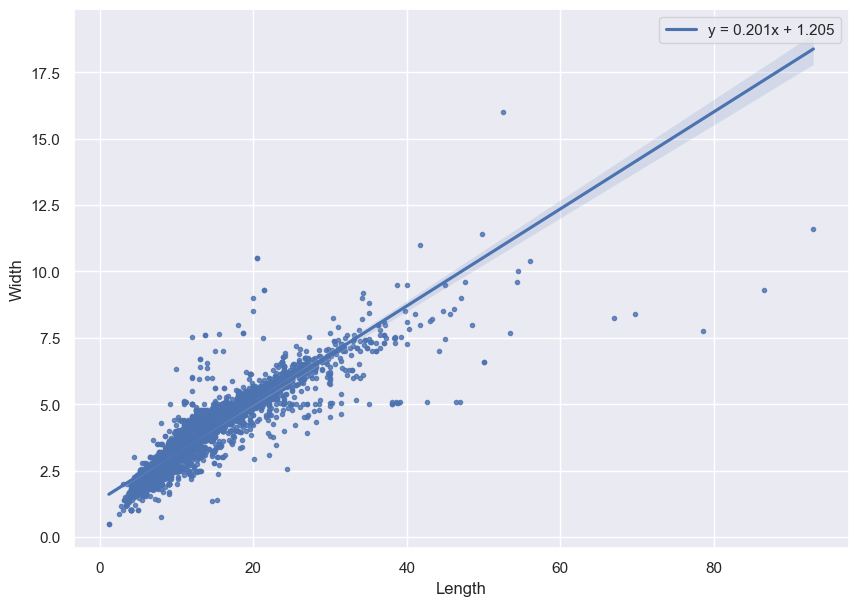

In [94]:
slope, intercept, r_value, p_value, std_err = stats.linregress(data_no_na['Length'], data_no_na['Width'])

ax = sns.regplot(x="Length", y="Width", data=data, line_kws={'label':f'y = {slope:.3f}x + {intercept:.3f}'}, marker='.')
ax.legend()

Let’s impute the missing width using the length column

In [95]:
imputed_data.loc[imputed_data['Width'].isnull(), 'Width'] = imputed_data['Length'] * slope + intercept

To impute the **Condition column** let’s just assume that the missing values are used boats.

In [96]:
imputed_data['Condition'] = imputed_data['Condition'].fillna('Used boat')

Let’s finish by imputing the **Age column** by using the views column. Let's just replace the missing values with the mean.

In [97]:
imputed_data.loc[imputed_data['Year Built'].isnull(), 'Year Built'] = data['Year Built'].mean()
imputed_data.loc[imputed_data['Age'].isnull(), 'Age'] = 2022 - imputed_data['Year Built']
imputed_data['Age Category'] = pd.cut(imputed_data['Age'], 
                                      bins=age_groups,
                                      labels=['Very New', 'New', 'Modern', 'Old', 'Very Old', 'Ancient'])

Let’s verify our data 

In [98]:
display(imputed_data.isna().sum())
print(f'The dataset has {imputed_data.shape[0]} rows and {imputed_data.shape[1]} columns')

Price                          0
Boat Type                      0
Manufacturer                   0
Year Built                     0
Length                         0
Width                          0
Material                       0
Location                       0
Number of views last 7 days    0
Currency                       0
Price Category                 0
Condition                      0
Fuel Type                      0
Age                            0
Age Category                   0
View Category                  0
dtype: int64

The dataset has 8258 rows and 16 columns


# <span style="color:#0066CC">Data Modeling</span>

The product manager of the website wants to know if we can predict the number of views a listing will recieve based on the boat’s features. This is an example of a regression problem since our target variable, number of views, is continuous .

### Feature Selection
Adding redundant variables reduces the generalization capability of the model. Also, adding more variables to a model increases the overall complexity of it.
It is important to find the best set of features that best adjusts to the problem.
In other words, selecting features:
* Reduces Overfitting: Less redundant data means less opportunity to make decisions based on noise.

* Improves Accuracy: Less misleading data means modeling accuracy improves.

* Reduces Training Time: fewer data points reduce algorithm complexity and algorithms train faster.


In [99]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import Lasso
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.feature_selection import mutual_info_regression

import time

In [100]:
feature_selection = imputed_data.copy()

Let’s drop the View Category from our dataset since we can't use it as a feature. 

In [101]:
feature_selection = feature_selection.drop(['View Category'], axis=1)

Lasso regression will automatically select those features that are useful, discarding the useless or redundant features. We are going to work with the numerical columns. 

In [102]:
X = feature_selection.drop('Number of views last 7 days', axis=1)
X = X.select_dtypes(include=[np.number])
y = feature_selection['Number of views last 7 days']

We are going to build our model and optimize the hyperparameters and train it.

It is important to scale our data since Lasso minimizes a loss function. Standardization works well when our data has lots of outliers. 

In [103]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso())
])

Now we have to optimize the $\alpha$ hyperparameter of Lasso regression. We are trying to minimize the mean squared error.

In [104]:
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1, 10, 0.1)},
                      cv = 5, 
                      scoring='neg_mean_squared_error')

We can now fit the grid search.

In [105]:
search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso())]),
             param_grid={'model__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
             scoring='neg_mean_squared_error')

In [106]:
print(f'Best value for α: {search.best_params_["model__alpha"]}')

Best value for α: 1.0


Let’s find out our coefficients

In [107]:
coefficients = search.best_estimator_.named_steps['model'].coef_

The sign of coefficients tells us if the independent variable is positively or negatively related to the outcome. So the importance of a feature is the absolute value of it's coefficient.

In [108]:
importance = np.abs(coefficients)

Let’s plot the results

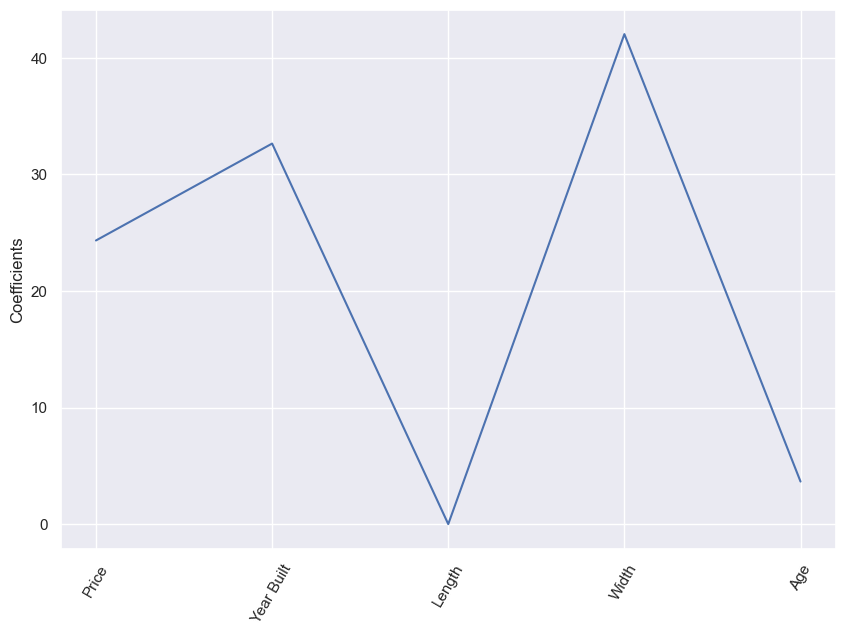

In [109]:
names = X.columns
plt.plot(range(len(names)), importance)
plt.xticks(range(len(names)), names, rotation=60)
plt.ylabel('Coefficients')
plt.show()

Length and Width are highly correlated features. It would make sense to only keep one. In this case, according to our regression the Length column has a coefficient of zero so we could drop it.

Let’s continue with the categorical feature selection.

Mutual information is an entropy-based method that identifies dependency between our target and each feature. It can capture nonlinear relationships.

In [110]:
X = feature_selection.drop('Number of views last 7 days', axis=1)
X = X.select_dtypes(exclude=np.number)

In [111]:
le = LabelEncoder()
for i in X.columns:
    le.fit(X[i])
    X[i] = le.transform(X[i]).copy()

In [112]:
mi = mutual_info_regression(X, y, discrete_features=True, n_neighbors=5)
mi_df = pd.DataFrame(mi, index=X.columns, columns=['mutual_information'])

Text(0.5, 1.0, 'Top Categorical Features')

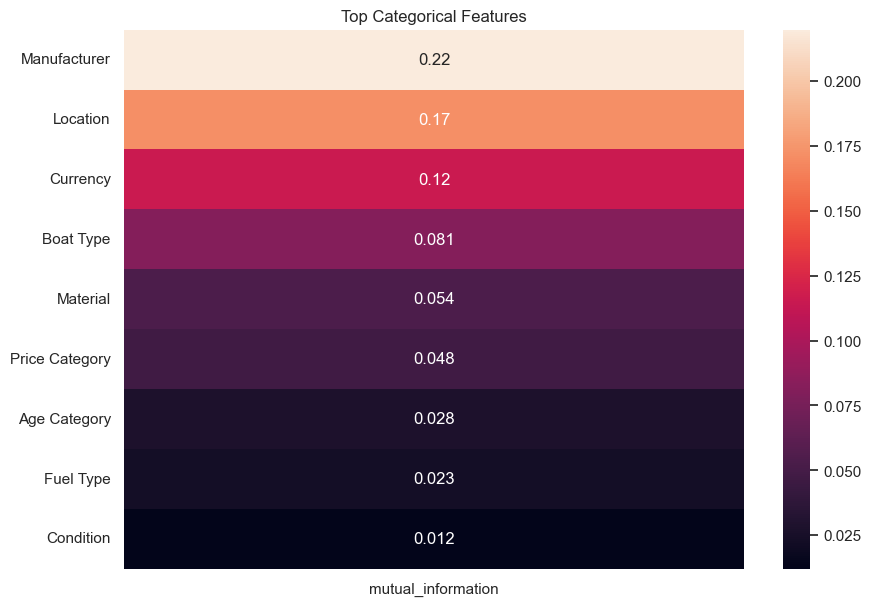

In [113]:
mi_top_features = mi_df.sort_values(by='mutual_information', ascending=False)
sns.heatmap(data=mi_top_features, annot=True)
plt.title('Top Categorical Features')

We can see how condition and fuel type are quite irrelevant. 

Let’s drop the following columns from our dataset.

In [114]:
modeling_data = feature_selection.copy()

### Modeling

Let’s start by dropping the features we don’t need. Age category and price category are made up features which are basically generalized categories of age and price, we can drop them. Age is also a modified year-built column, so we can drop either one.

In [115]:
drop_columns = ['Condition', 'Fuel Type', 'Age Category', 'Price Category', 'Length', 'Year Built']
modeling_data = modeling_data.drop(drop_columns, axis=1)

We are evaluating the performance of our regression.
Since the success criteria is seeing how much the prediction is off from the actual value as a percentage, we should consider using the mean average percentage error, MAPE for short.

A model’s performance is dependent on the way the data is split; this isn’t representative of the model’s ability to generalize. The solution is to cross validate.

However, there is a problem. There are many Locations and Manufacturers which have a frequency of 1. This means that the model could eventually test unseen data. We could solve this by dropping these two columns, but this would mean that we are losing our most relevant features. The other solution would be to drop the rows with low occurring locations and manufacturers.

Let’s begin by dropping Location and Manufacturer.

In [116]:
modeling_data_no_L_M = modeling_data.drop(['Location', 'Manufacturer'], axis=1)

In [117]:
X = modeling_data_no_L_M.drop('Number of views last 7 days', axis=1)
y = modeling_data_no_L_M['Number of views last 7 days']

Machine learning models can’t understand categorical features. Let’s create a pipeline to encode and scale our data.

In [118]:
numeric_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(exclude=np.number).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(), categorical_features),
    ]
)

To choose our estimator, we are going to use the Estimator flowchart in scikit-learns website. [Flowchart](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)

We are predicting a quantity and we have less than 100k samples. So, let’s begin by checking the following regressors:
* Linear regression (baseline model)
* Lasso
* Ridge
* SVR(kernel='linear')
* Ensemble regressors

In [119]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

In [120]:
models = [
    ('LinearRegression', LinearRegression()),
    ('Lasso', Lasso()),
    ('Ridge', Ridge()),
    ('SVR_linear', SVR(kernel='linear')),
    ('RandomForest', RandomForestRegressor()),
]

In [121]:
for name, model in models:
    reg = Pipeline(
        steps=[("preprocessor", preprocessor), ("regressor", model)]
    )
    start_time = time.time()
    cv_result = cross_val_score(reg, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='neg_mean_absolute_percentage_error')
    print(f'{name: <20} {np.nanmean(-cv_result) * 100: >10.2f}% {"":>10} Execution Time: {time.time() - start_time: .2f}s')

LinearRegression          62.68%            Execution Time:  0.17s
Lasso                     64.79%            Execution Time:  0.14s
Ridge                     62.61%            Execution Time:  0.14s
SVR_linear                49.40%            Execution Time:  10.76s
RandomForest              57.79%            Execution Time:  61.74s


Compared to the linear regression and to the other models, SVR performs the best. It improves the linear regression by roughly 13% yet it does take longer to compute. Random Forest also performs well however it is much slower than the other models.

We did drop our most relevant features, let’s clean up our data so that we can include these columns (Location and Manufacturer)

In [122]:
modeling_data_with_L_M = modeling_data.copy()

In [123]:
for _ in range(3):
    for i in modeling_data_with_L_M.select_dtypes(exclude=np.number).columns:
        # Let’s group together boat feature cateogries that have less than 20 records and filter them out
        frequent_category = pd.Series(modeling_data_with_L_M[i].value_counts() > 20)
        frequent_category = frequent_category[frequent_category == True].index.tolist()
        modeling_data_with_L_M.loc[~modeling_data_with_L_M[i].isin(frequent_category), i] = np.nan
        modeling_data_with_L_M = modeling_data_with_L_M[modeling_data_with_L_M[i].notna()]

In [124]:
X = modeling_data_with_L_M.drop('Number of views last 7 days', axis=1)
y = modeling_data_with_L_M['Number of views last 7 days']

In [125]:
numeric_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(exclude=np.number).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(), categorical_features),
    ]
)

In [126]:
for name, model in models:
    reg = Pipeline(
        steps=[("preprocessor", preprocessor), ("regressor", model)]
    )
    start_time = time.time()
    cv_result = cross_val_score(reg, X, y, cv=StratifiedKFold(n_splits=10, shuffle=True), scoring='neg_mean_absolute_percentage_error')
    print(f'{name: <20} {np.nanmean(-cv_result) * 100: >10.2f}% {"":>10} Execution Time: {time.time() - start_time: .2f}s')

LinearRegression          54.18%            Execution Time:  0.37s
Lasso                     58.01%            Execution Time:  0.42s
Ridge                     54.15%            Execution Time:  0.28s
SVR_linear                44.69%            Execution Time:  12.80s
RandomForest              47.91%            Execution Time:  101.36s


We can clearly see how all models have improved. SVR linear is still the best one, let’s see if we can further improve it by tuning the hyperparameters.

In [127]:
reg = Pipeline(
        steps=[("preprocessor", preprocessor), ("regressor", SVR(kernel='linear'))]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

param_vals = {'regressor__C': [1, 2, 3],
             'regressor__epsilon': [0.05, 0.1, 0.15]}

search = GridSearchCV(reg,
                      param_grid=param_vals,
                      cv=StratifiedKFold(n_splits=5, shuffle=True), 
                      scoring='neg_mean_squared_error',
                      refit=True, verbose=1, error_score="raise")

search.fit(X, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['Price', 'Width', 'Age'], dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         Index(['Boat Type', 'Manufacturer', 'Material', 'Location', 'Currency'], dtype='object'))])),
                                       ('regressor', SVR(kernel='linear'))]),
             param_grid={'regressor__C': [1, 2, 3],
                         'regressor__epsilon': [0.05, 0.1, 0.15]},
             scoring='neg_mean_squared_error', verbose=1)

In [128]:
search.best_params_

{'regressor__C': 3, 'regressor__epsilon': 0.05}

### Results

In [129]:
preds = search.best_estimator_.predict(X_test)

Let’s calculate the MAPE.

In [130]:
MAPE = mean_absolute_percentage_error(y_test, preds) * 100
print(f'Mean absolute percentage error: {MAPE:.2f}%')

Mean absolute percentage error: 42.10%


This basically tells us that on average the forecasted quantities were roughly 43% off from the actual quantities.

In [131]:
success_criteria = 50
print(f'Is the model successful? {MAPE < success_criteria}')

Is the model successful? True


However, how does this model perform within each view category? The manager is interested in listing boats that receive lots of views.

In [132]:
data = pd.merge(modeling_data_with_L_M, imputed_data, how='inner')
data = data.drop(drop_columns, axis=1)

In [133]:
view_categories_names = ['Very Unpopular', 'Unpopular', 'Average', 'Popular', 'Very Popular']
view_categories_MAPE = []
for category in view_categories_names:
    category = data[data['View Category'] == category]
    X_cat = category.drop(['View Category', 'Number of views last 7 days'], axis=1)
    y_cat = category['Number of views last 7 days']
    X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_cat, test_size=0.2, random_state=42)
    preds_cat = search.best_estimator_.predict(X_test_cat)
    MAPE_cat = mean_absolute_percentage_error(y_test_cat, preds_cat) * 100
    view_categories_MAPE.append(MAPE_cat)

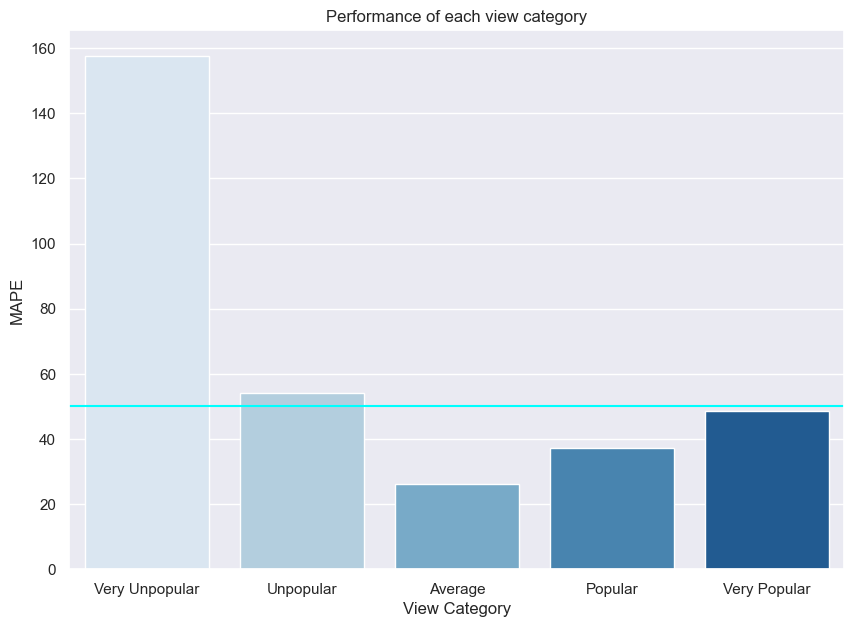

In [134]:
ax = sns.barplot(x=view_categories_names, y=view_categories_MAPE, palette='Blues')
ax.set(title='Performance of each view category')
ax.set_ylabel("MAPE")
ax.set_xlabel("View Category")
plt.axhline(y=50, color='cyan')

We must consider that we are testing on already trained data, so the predictions are optimistic. Our model performs well when trying to predict Average, Popular and Very Popular boats. 

# <span style="color:#0066CC">Conclusion and Business Focus</span>

Our model was successful; our predictions are on average roughly 43% off of the true number of views a listing would receive.

Future recommendations, improve overall the data quality. There were many missing values and lots of listings had wrong data. A simple data validator could be used on the website to avoid problems.
The business should focus on Europe, particularly with Switzerland. They could make marketing efforts on small cabin boats and, above all, with cheap boats.


We saw how adding the location and the manufacturer to our model improved it. As a business, the manager should make these two values mandatory before a person is able to list a boat.

We saw previously how this model is well suited for predicting views in popular and very popular boats. This is very useful for the manager since his goal wants to prevent listing boats that do not receive many views.

### Business Metrics

How would the manager know if a boat should be listed? We should check whether the predicted view of the boat falls either in Average, Popular or Very Popular. To do this, lets recall our view categories.

In [135]:
view_category

[12, 40, 70, 170, 300, 3264]

Boats under 70 views are unpopular and above 170 are popular. To simplify the process and to not filter out too many boats let’s just say that the manager is interested in boats that have more than 130 views. These are average boats, which lean more towards being popular ones.

In [136]:
def metric(views: float, threshold: int = 120) -> bool:
    if views >= threshold:
        return True
    return False

In [137]:
vfunc = np.vectorize(metric)
metric_values = pd.Series(vfunc(preds))
metric_values.value_counts(normalize=True)

False    0.677123
True     0.322877
dtype: float64

We can see how our metric filter out two thirds of the data. This means that 32% of the boats listed are considered popular and valuable by the manager. Now let’s compare if our true values did in fact have more than 120 views.

In [138]:
evaluation = y_test[metric_values.values] > 120
evaluation.value_counts(normalize=True)

True     0.71564
False    0.28436
Name: Number of views last 7 days, dtype: float64

Out of the 32%, only 71% of the boats were truly popular and valuable by the manager.

Another metric the manger could use would be checking if any of the boats listed belong to the popular categories previously analyzed. These are: 
* Very Cheap, Cheap Price, Modest Category
* Old or Very Old Age, Modern Category
* From Switzerland and listed in CHF
* Manufactured by Windy, Bayliner, Riva, Regal, Bavaria, or Sea Ray
* Cabin boats, Wakeboards, Classic, Offshore Boats, Runabout, Fishing Boats

However let's not focus on the country nor the manufacturer since they were very specific

In [139]:
def check_categories(data: pd.DataFrame) -> pd.Series:
    temp = data[data['Price Category'].isin(['Very Cheap', 'Cheap', 'Modest']) 
                & data['Age Category'].isin(['Very Old', 'Old', 'Modern']) 
                & data['Boat Type'].isin(['Cabin Boat', 'Wakeboard/Wakesurf', 'Classic', 'Offshore Boat', 'Runabout', 'Fishing Boat', 'Mega Yacht', 'Sport Boat'])]
    return temp

In [140]:
valid_boats = check_categories(feature_selection)
print(f'Amount of boats: {feature_selection.shape[0]}')
print(f'Valid boats: {valid_boats.shape[0]}')
print(f'Percentage: {valid_boats.shape[0] / feature_selection.shape[0] * 100:.2f}%')

Amount of boats: 8258
Valid boats: 644
Percentage: 7.80%


It’s evident that checking categories drops a lot of data, the conditions set are too rigorous. Let’s check if it was worth it by evaluation how many of these valid boats actually are popular (have more than 120 views)

In [141]:
(valid_boats['Number of views last 7 days'] > 120).value_counts(normalize=True)

True     0.798137
False    0.201863
Name: Number of views last 7 days, dtype: float64

Out of the 644 boats, roughly 80% were truly popular. We can see that this second approach is slightly better than the previous approach.

In conclusion the manager has the difficult task of filtering out unpopular boats, he should consider checking first if any listed boat belongs in the popular categories by using the check category function. Just because a boat returns False doesn’t mean he should discard it, he should then proceed and run the model to further confirm if the boat should be listed by running the output through the metric.